## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [44]:
import simulators.mass_function_n_counts.simulator_trapz_m500_3 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_m500_3' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [7]:
theta_fiducial = np.array([0.1197, 0.76])


## Define mass calibration parameters

In [14]:
mass_calibration_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}']
                                #'Y_{*}', 'M_{*}', 
                                #'\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']
theta_fiducial_mass_calibration = np.array([1.79, 0., 0.]) #, 2.4e-10, 1e14, 0., 0., 0.127])

In [15]:
theta_total = np.concatenate((theta_fiducial, theta_fiducial_mass_calibration))
theta_total

array([0.1197, 0.76  , 1.79  , 0.    , 0.    ])

In [16]:
z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
n_steps_z = 100
n_bins_z = len(z_min)


n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

n_steps_Mz = n_steps_z*n_steps_M_500

Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16),
                 np.logspace(np.log10(4.3e-12), np.log10(5.1e-10), num = 15)[:-2],
                 np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 16)[:13],
                 np.logspace(np.log10(3.1e-12), np.log10(1.1e-10), num = 14)[:8],
                 np.logspace(np.log10(2.5e-12), np.log10(6.6e-11), num = 13)[:7]]

n_steps_Y = 100

In [17]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_m500_3' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py'>

In [45]:
N_countsSimulator = n_counts_simulator.Model(Y_bins_limits=Y_bins_limits)

/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


In [46]:
N_countsSimulator.N_counts

array([9.78870244e+03, 6.69016731e+03, 4.47538808e+03, 2.92613922e+03,
       1.86808090e+03, 1.16404436e+03, 7.08293014e+02, 4.21444809e+02,
       2.45804082e+02, 1.40970427e+02, 7.97764196e+01, 4.46953853e+01,
       2.48573278e+01, 1.37486210e+01, 7.57130679e+00, 1.20179384e+04,
       7.81952509e+03, 4.93854626e+03, 3.01753042e+03, 1.77726645e+03,
       1.00497426e+03, 5.43179855e+02, 2.79265103e+02, 1.35843343e+02,
       6.21429223e+01, 2.65550043e+01, 1.05201230e+01, 5.35649180e+03,
       3.47886179e+03, 2.20015751e+03, 1.35159987e+03, 8.04477160e+02,
       4.62568533e+02, 2.56146873e+02, 1.36151996e+02, 6.92010438e+01,
       3.35004108e+01, 1.53789914e+01, 6.66219773e+00, 1.26255271e+03,
       7.14028039e+02, 3.88493467e+02, 2.02631571e+02, 1.00909738e+02,
       4.77967481e+01, 2.14266018e+01, 3.97074686e+02, 1.98821723e+02,
       9.50816189e+01, 4.32673161e+01, 1.86417427e+01, 7.57233398e+00])

In [47]:
N_counts = N_countsSimulator.simulation(theta_total, 1)
N_counts

simulation time: 4.397179062999982


array([ 9813,  6612,  4412,  2907,  1852,  1125,   696,   392,   234,
         119,    69,    34,    37,    16,     8, 11969,  7722,  4804,
        3008,  1718,   915,   501,   280,   128,    57,    26,    12,
        5411,  3482,  2134,  1318,   799,   420,   245,   128,    79,
          29,    20,     6,  1196,   714,   393,   221,    84,    23,
          17,   390,   209,    85,    36,    16,     4])

## Priors on parameters

In [21]:
lower = np.array([0.1125, 0.6, 1.6, -0.1, -0.3])
upper = np.array([0.1275, 1.1, 2.0, 0.1, 0.3])
prior = priors.Uniform(lower, upper)

param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}',
               '\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}']

In [22]:
param_names

['\\Omega_{cdm}h^{2}',
 '\\sigma_{8}',
 '\\alpha_{Y}',
 '\\beta_{Y}',
 '\\gamma_{Y}']

## Set up simulator

In [48]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up compressor for now

In [24]:
def compute_derivative(theta_fiducial, theta_mass_calibration, param_index, delta_param, 
                      z_min, z_max, Y_bins_limits):
    
    theta_2h = theta_fiducial
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_2h, theta_mass_calibration)
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_h, theta_mass_calibration)
    
    
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                        theta_h_neg, theta_mass_calibration)
    
    
    
    
    theta_2h_neg = theta_fiducial
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                         theta_2h_neg, theta_mass_calibration)
    
    
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

In [25]:
def compute_derivative_mass(theta_fiducial, theta_mass_calibration, param_index, delta_param, 
                      z_min, z_max, Y_bins_limits):
    
    theta_2h = theta_mass_calibration
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_fiducial, theta_2h)
    
    theta_h = theta_mass_calibration
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_fiducial, theta_h)
    
    
    
    theta_h_neg = theta_mass_calibration
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                        theta_fiducial, theta_h_neg)
    
    
    
    
    theta_2h_neg = theta_mass_calibration
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                         theta_fiducial, theta_2h_neg)
    
    
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

In [26]:
mu = N_countsSimulator.N_counts
Cinv = np.linalg.inv(np.diag(N_countsSimulator.N_counts))

In [27]:
deriv_omega_cdm = compute_derivative(theta_fiducial, theta_fiducial_mass_calibration, 0, 0.01*theta_fiducial[0],
                                     z_min, z_max, Y_bins_limits)
deriv_sigma8 = compute_derivative(theta_fiducial, theta_fiducial_mass_calibration, 1, 0.01*theta_fiducial[1], 
                                  z_min, z_max, Y_bins_limits)

In [28]:
delta_param_mass = 0.01*theta_fiducial_mass_calibration
delta_param_mass

array([0.0179, 0.    , 0.    ])

In [29]:
delta_param_mass[1] = 0.01
delta_param_mass[2] = 0.025


In [30]:
delta_param_mass

array([0.0179, 0.01  , 0.025 ])

In [31]:
derivs = []
for i in range(len(theta_fiducial_mass_calibration)):
    deriv_temp = compute_derivative_mass(theta_fiducial, theta_fiducial_mass_calibration, i, 
                                        delta_param_mass[i], 
                                        z_min, z_max, Y_bins_limits)
    derivs.append(deriv_temp)
    print(i)

0
1
2


In [32]:
dmudt = np.stack((deriv_omega_cdm, deriv_sigma8))
for i in range(len(theta_fiducial_mass_calibration)):
    dmudt = np.vstack((dmudt, derivs[i]))

In [33]:
Compressor = score.Gaussian(len(N_counts), theta_total, mu = mu, Cinv = Cinv, dmudt = dmudt)

In [34]:
Compressor.compute_fisher()

In [35]:
Finv = Compressor.Finv
Finv.shape

(5, 5)

In [36]:
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load data

In [37]:
N_counts_data =  N_countsSimulator.simulation(theta_total, 1)
N_counts_data

array([ 9813,  6612,  4412,  2907,  1852,  1125,   696,   392,   234,
         119,    69,    34,    37,    16,     8, 11969,  7722,  4804,
        3008,  1718,   915,   501,   280,   128,    57,    26,    12,
        5411,  3482,  2134,  1318,   799,   420,   245,   128,    79,
          29,    20,     6,  1196,   714,   393,   221,    84,    23,
          17,   390,   209,    85,    36,    16,     4])

In [38]:
compressed_data = compressor(N_counts_data, compressor_args)

In [39]:
compressed_data

array([0.14232736, 0.65324173, 1.93710034, 0.09874331, 0.97138469])

In [40]:
n_params = len(theta_total)
print(n_params)
n_data_points = len(compressed_data)
print(n_data_points)

5
5


## Define ensemble of NDEs

In [41]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [49]:
t1 = time.process_time()
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_total, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}', '\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}'],
                            results_dir = "simulators/mass_function_n_counts/results_Y500_fisher/", 
                            input_normalization="fisher")
t2 = time.process_time()
print(t2-t1)

11.226757211000034


## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...
Done.
Removed no burn in


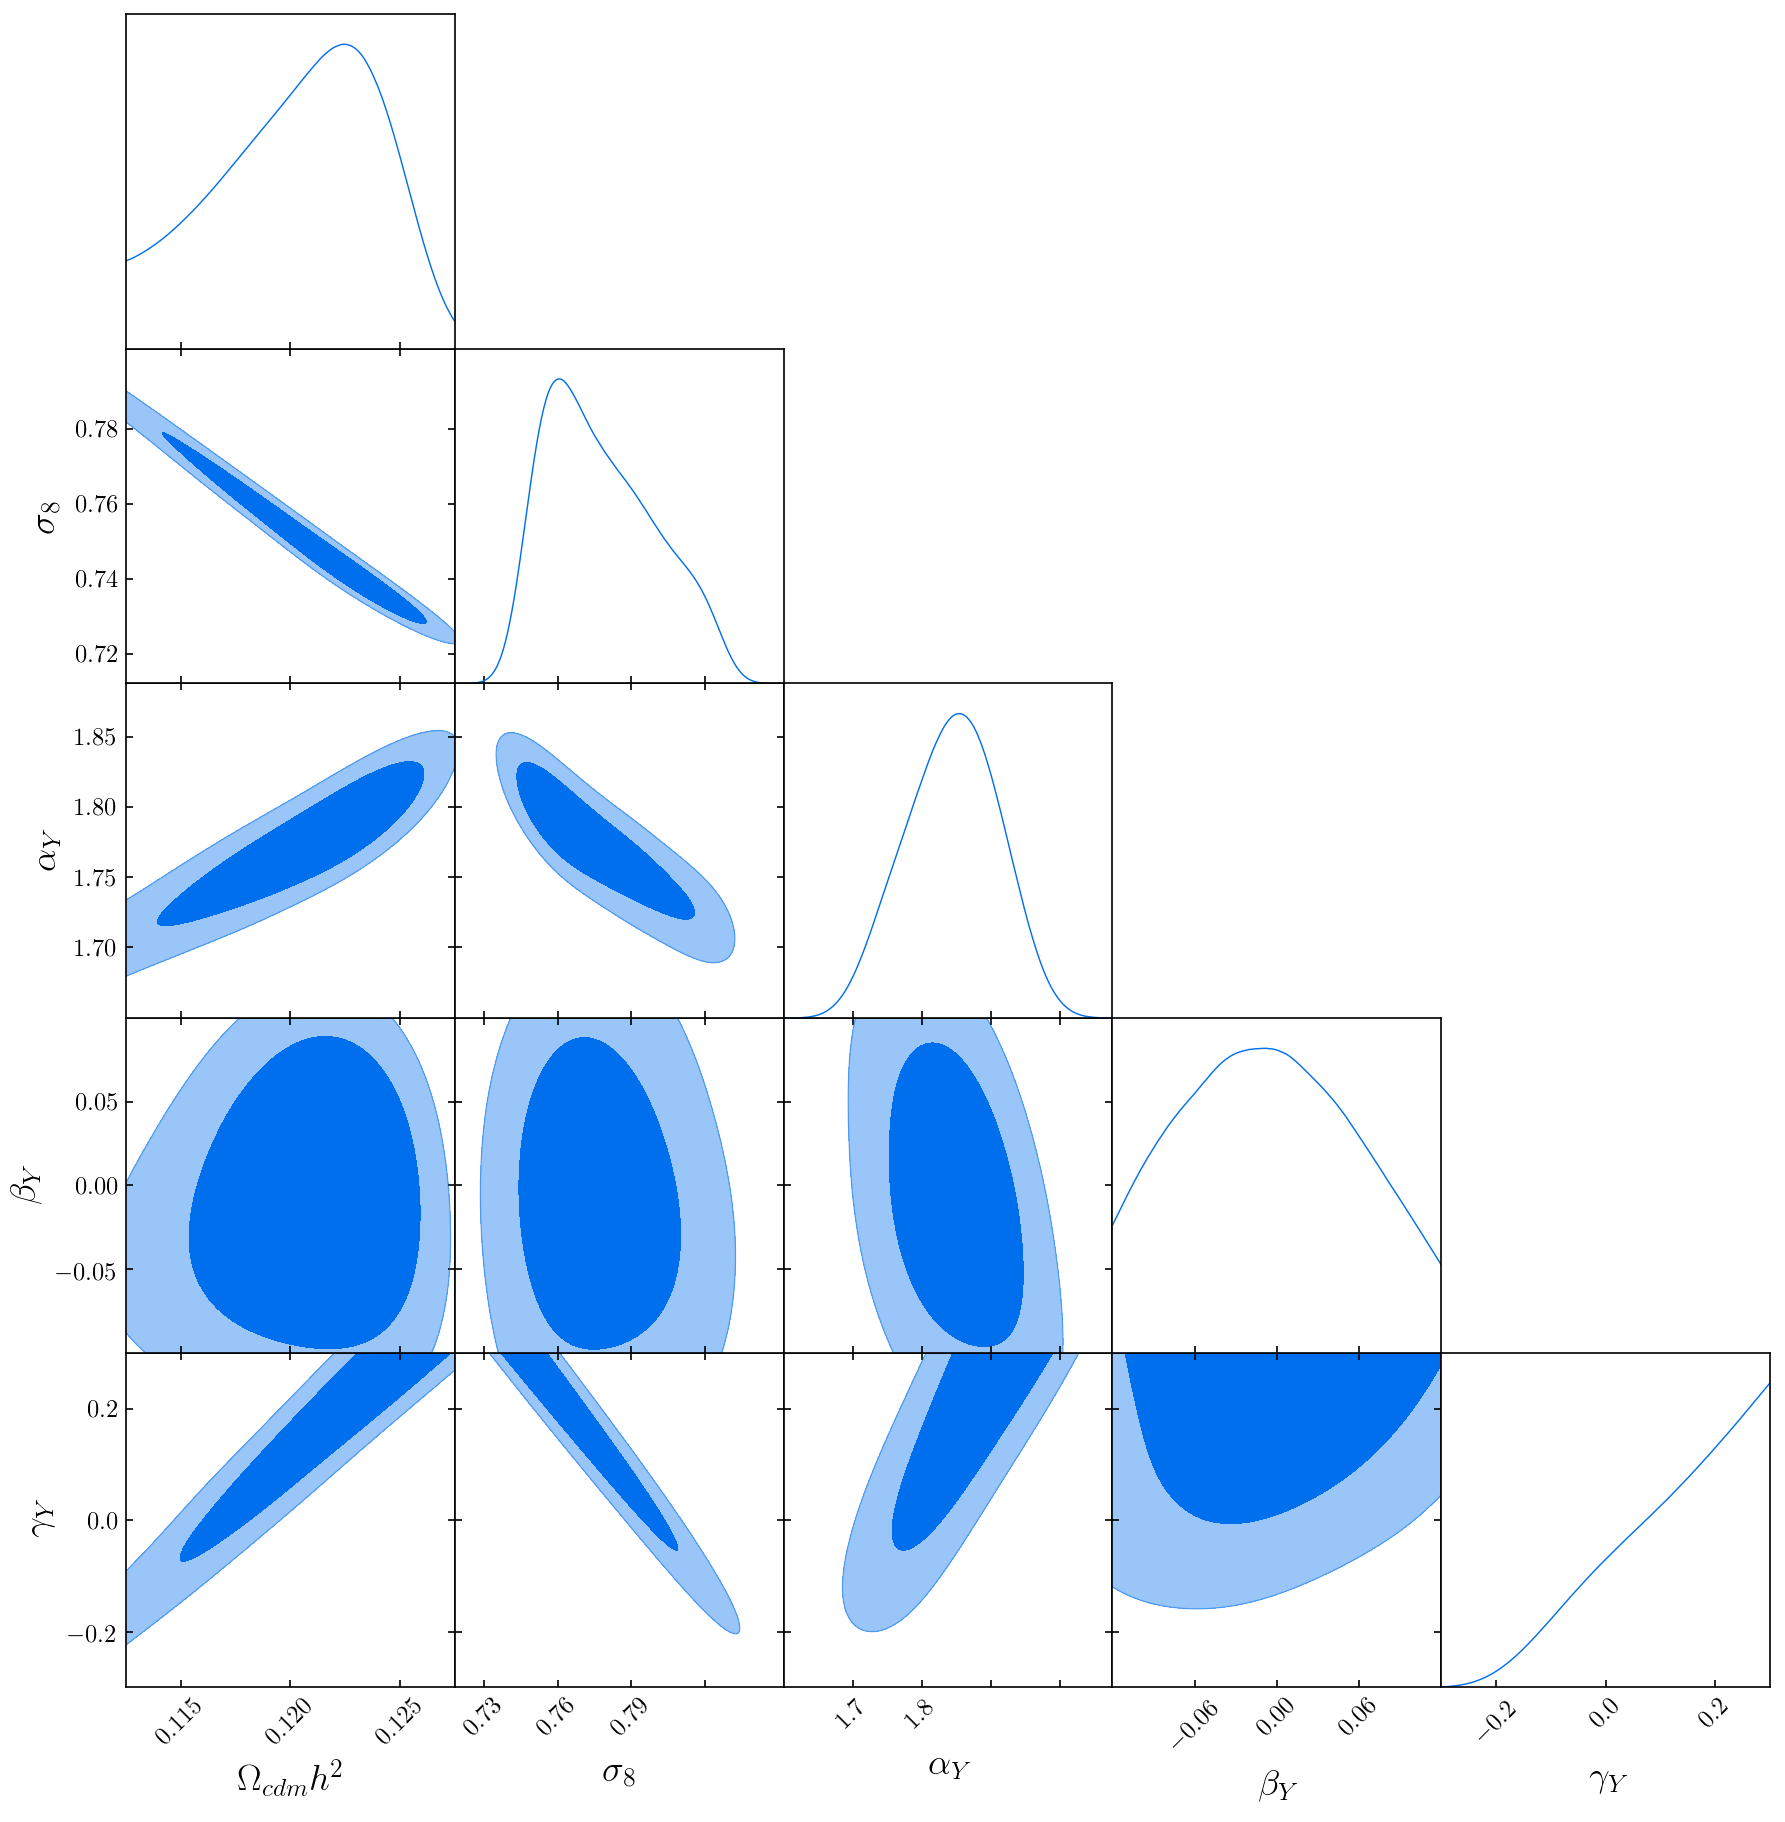

1492.41372063


In [50]:
t1 = time.process_time()
DelfiEnsemble.fisher_pretraining()
t2 = time.process_time()
print(t2-t1)

## Sequential Neural Likelihood

In [51]:
n_initial = 100 
n_batch = 100 
n_populations = 10

/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.285070546000043
simulation time: 4.270423312000048
simulation time: 4.308826117000081
simulation time: 4.2994389550001415
simulation time: 4.296771620000072
simulation time: 4.2991563380001026
simulation time: 4.289653482999938
simulation time: 4.3105483679999
simulation time: 4.309621351999795
simulation time: 4.296522373000016
simulation time: 4.2871573899999476
simulation time: 4.293056490000026
simulation time: 4.291285935000133
simulation time: 4.263696852000066
simulation time: 4.287731126999915
simulation time: 4.278322674000037
simulation time: 4.301897707999842
simulation time: 4.302317007999818
simulation time: 4.301662610999983
simulation time: 4.268310265000082
simulation time: 4.283017801000142
simulation time: 4.286311059999889
simulation time: 4.27319506799995
simulation time: 4.289796810000098
simulation time: 4.287592719000031
simulation time: 4.262713329000007
simulation time: 4.288697206000052
simulation time: 4.291058456999963
simulation time: 4.2

Sampling approximate posterior...
Done.
Removed no burn in


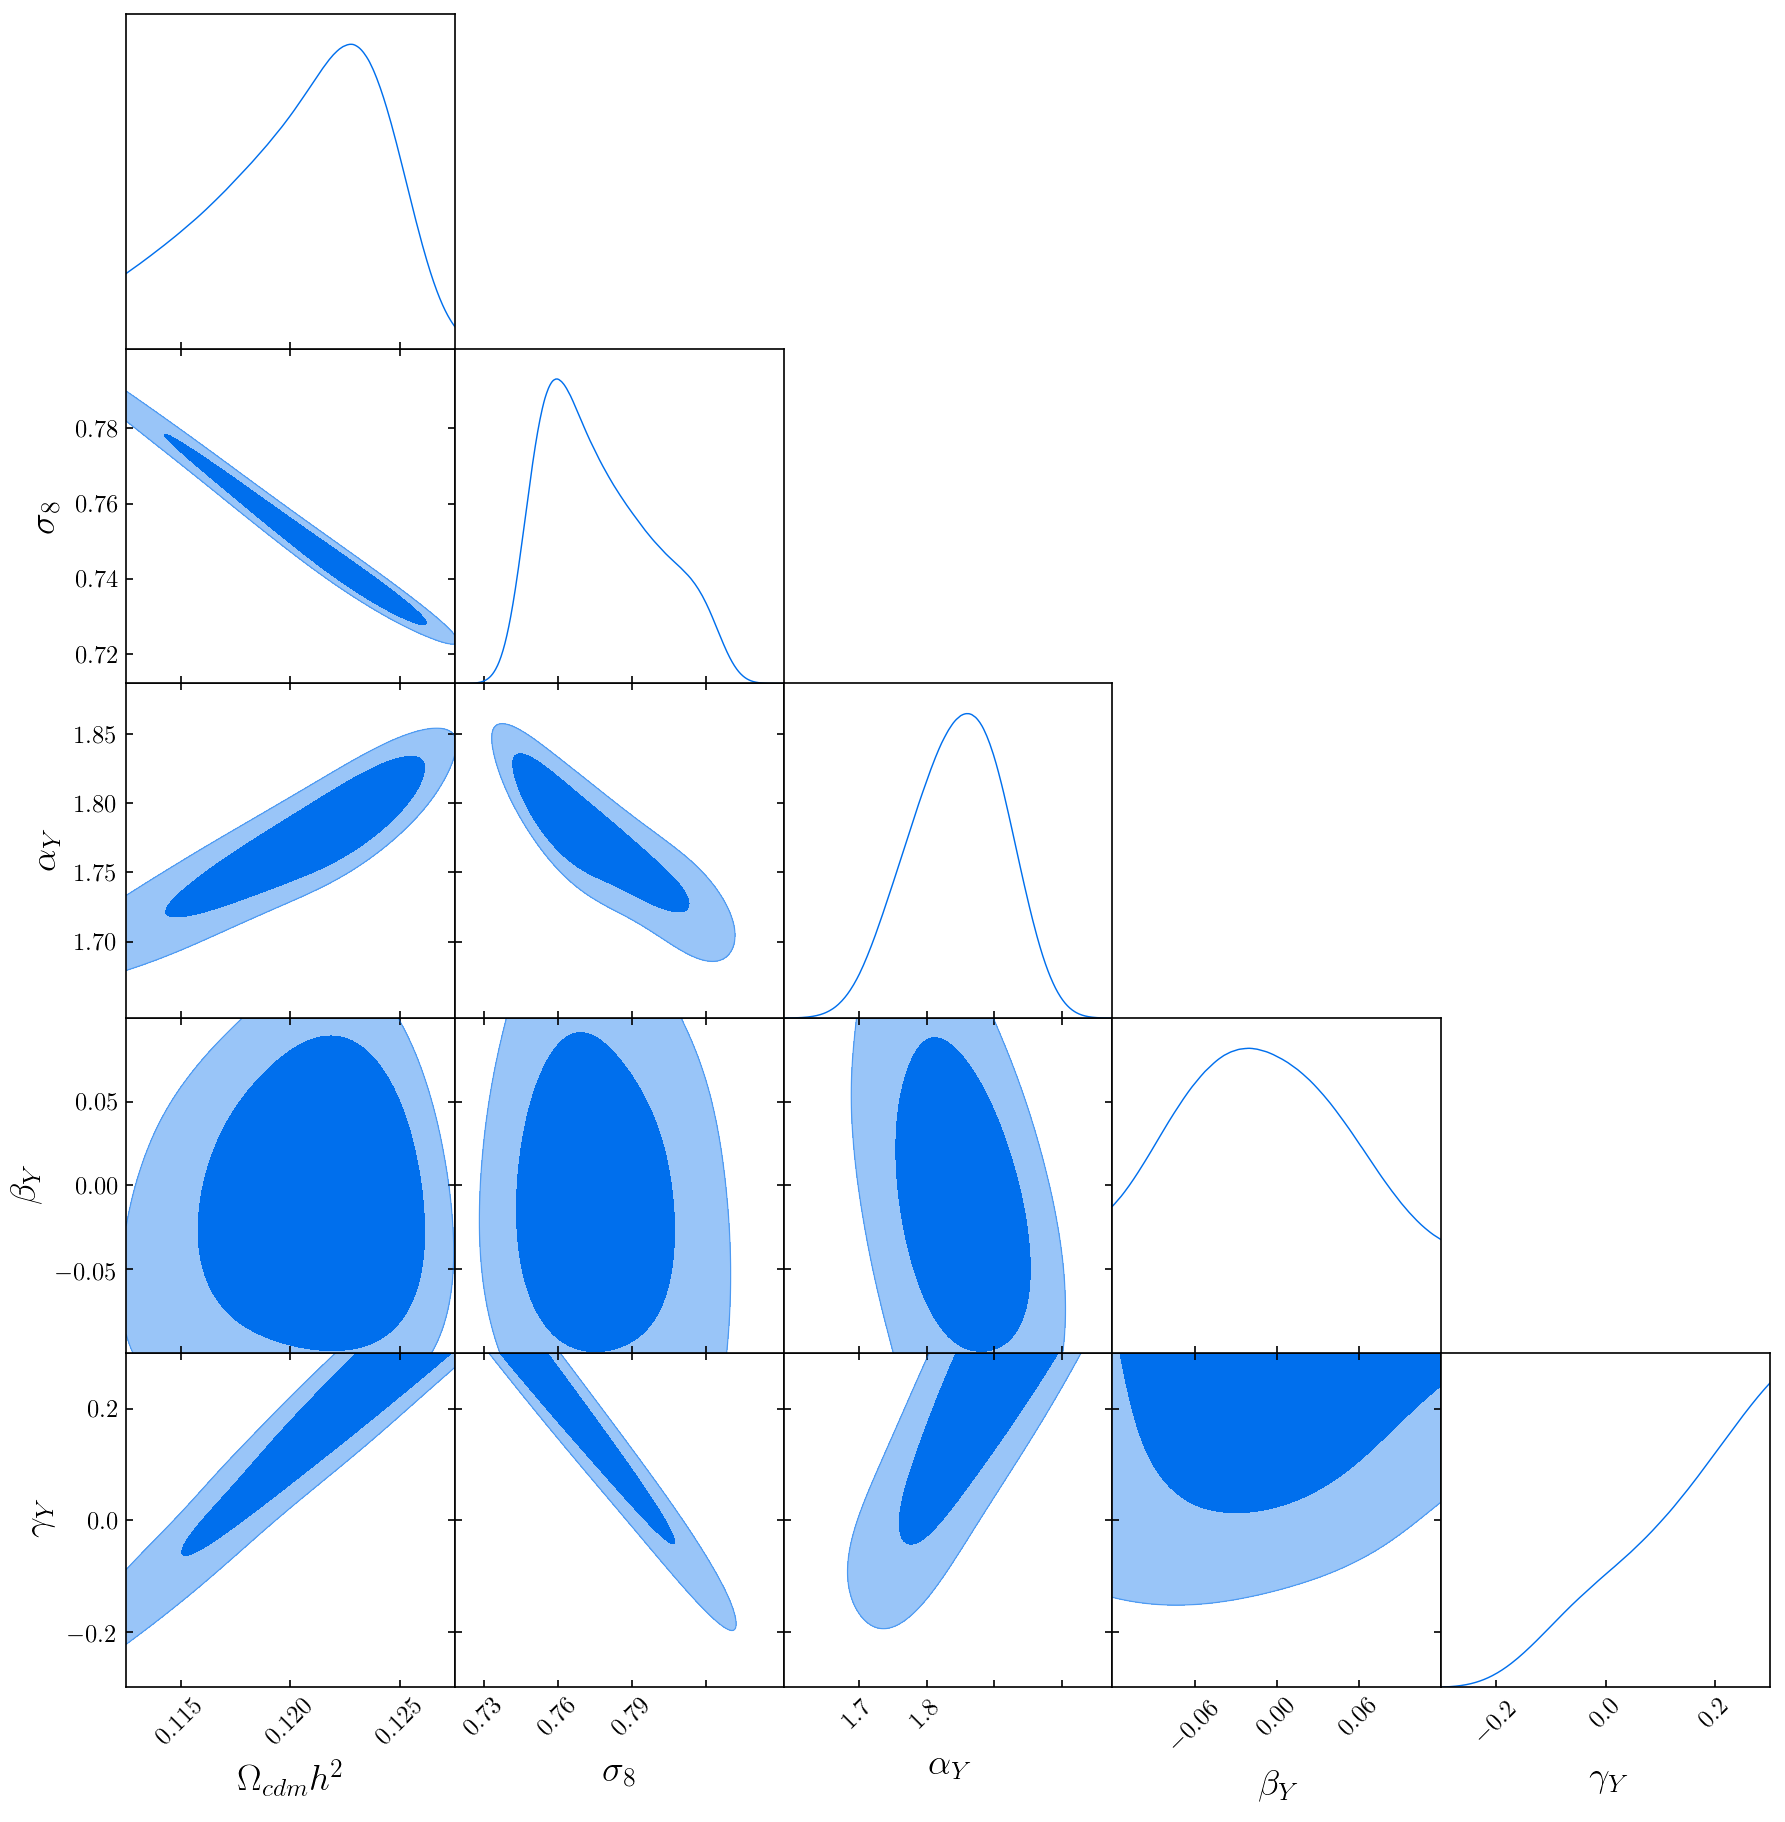

Population 1/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.286457577999954
simulation time: 4.299250238000241
simulation time: 4.303626386999895
simulation time: 4.285113864000323
simulation time: 4.284726433999822
simulation time: 4.285032858999784
simulation time: 4.285715795999749
simulation time: 4.2714965370000755
simulation time: 4.282615837999856
simulation time: 4.2822745589996885
simulation time: 4.278337641999769
simulation time: 4.242057182999815
simulation time: 4.255675209999936
simulation time: 4.282913303999976
simulation time: 4.292284549999749
simulation time: 4.291026324000086
simulation time: 4.283088676999796
simulation time: 4.278316949999862
simulation time: 4.280572911000036
simulation time: 4.285092211000119
simulation time: 4.291136981999898
simulation time: 4.292181054000139
simulation time: 4.274233437000021
simulation time: 4.293078167999738
simulation time: 4.275580166000054
simulation time: 4.294088441999975
simulation time: 4.2821388520001165
simulation time: 4.292612526999619
simulation time: 

Sampling approximate posterior...
Done.
Removed no burn in


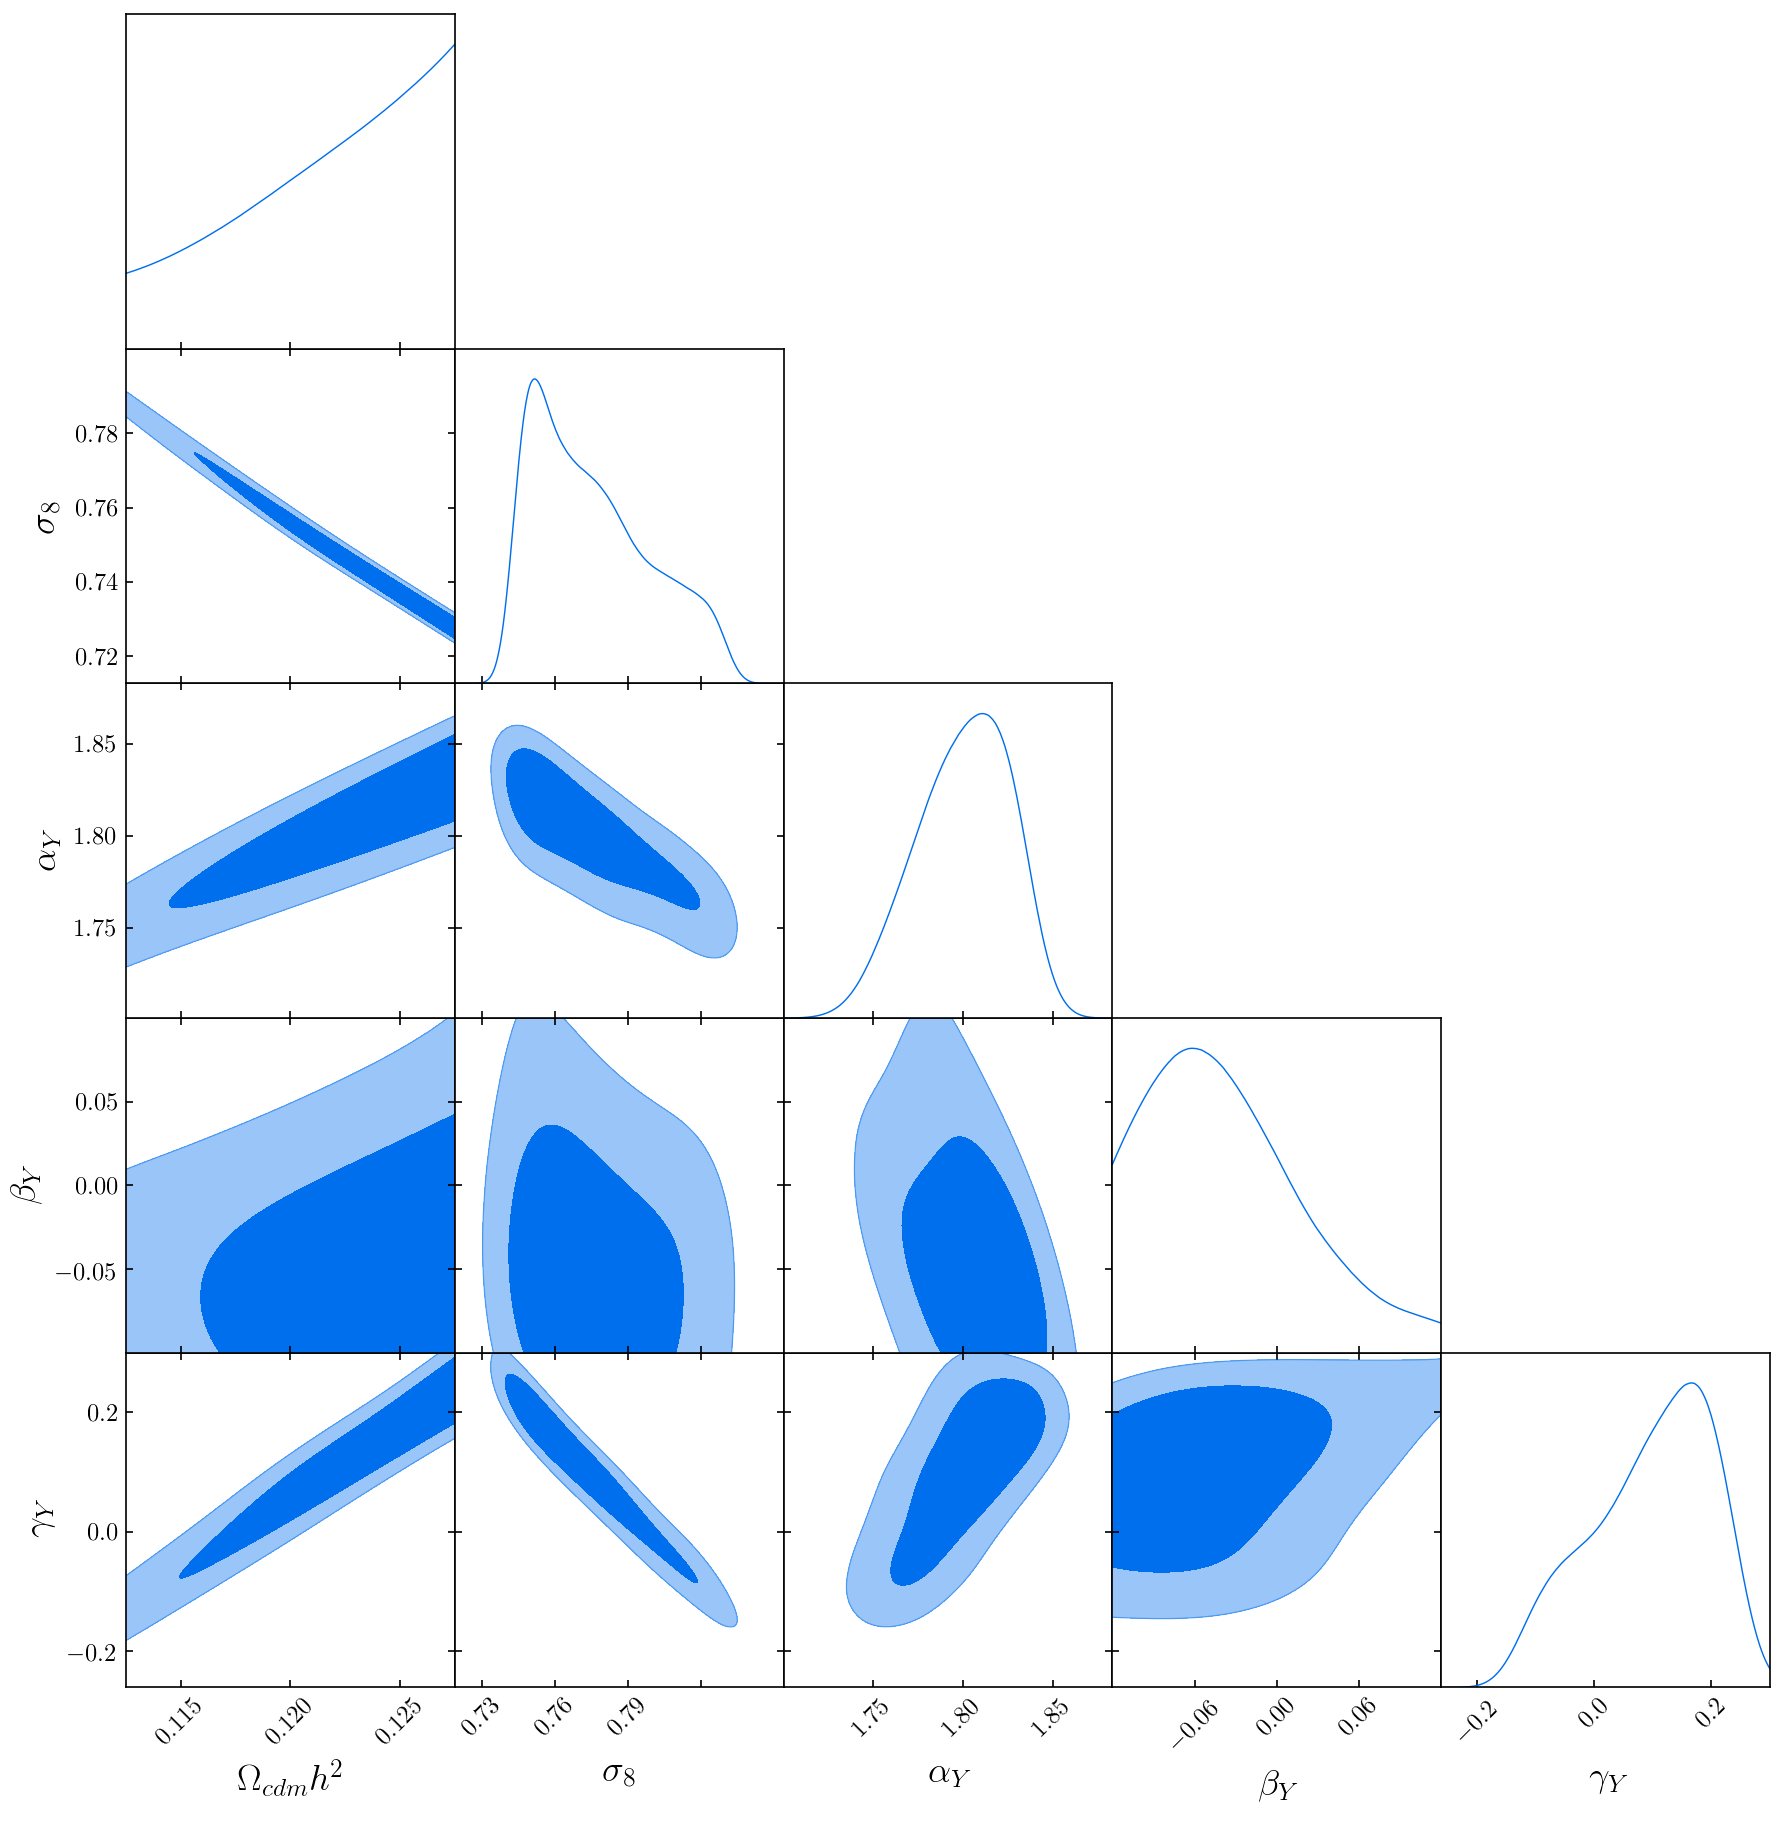

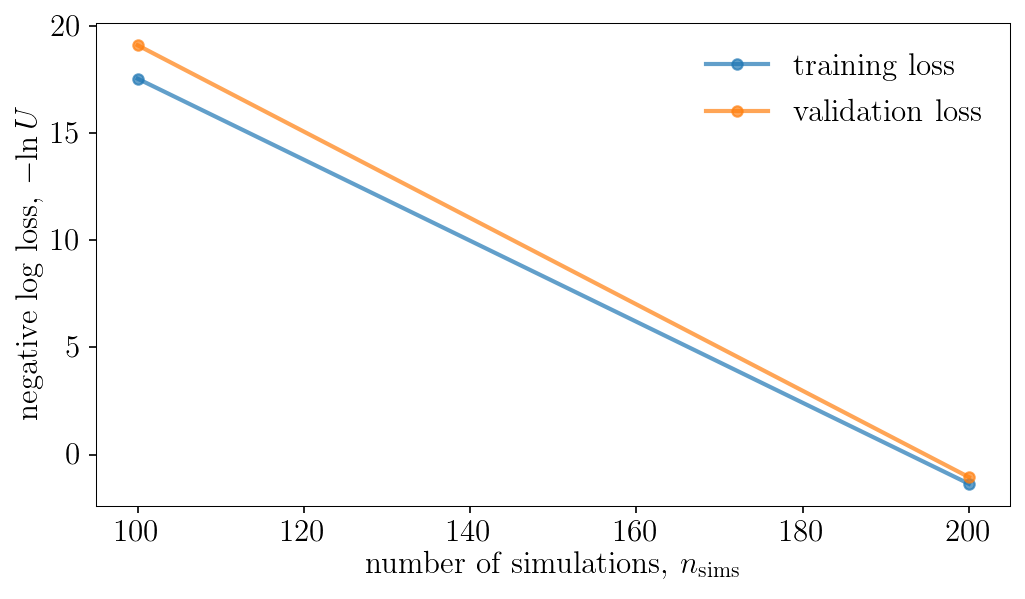

Population 2/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.26566988400009
simulation time: 4.258271502000298
simulation time: 4.261860568999964
simulation time: 4.2878076840001995
simulation time: 4.271195063999585
simulation time: 4.263686536000023
simulation time: 4.268019926999841
simulation time: 4.263619151000057
simulation time: 4.258165405
simulation time: 4.259647959000176
simulation time: 4.272948797000026
simulation time: 4.237014776000251
simulation time: 4.240103466000164
simulation time: 4.268378797999958
simulation time: 4.272489067000151
simulation time: 4.270279933999973
simulation time: 4.262542348000352
simulation time: 4.266762693000146
simulation time: 4.26372877599988
simulation time: 4.266412716999639
simulation time: 4.25082151200013
simulation time: 4.265568628999972
simulation time: 4.276782463000018
simulation time: 4.260686631999761
simulation time: 4.2611222770001405
simulation time: 4.272766129000047
simulation time: 4.266718623000088
simulation time: 4.251672176000284
simulation time: 4.26005169

Sampling approximate posterior...
Done.
Removed no burn in


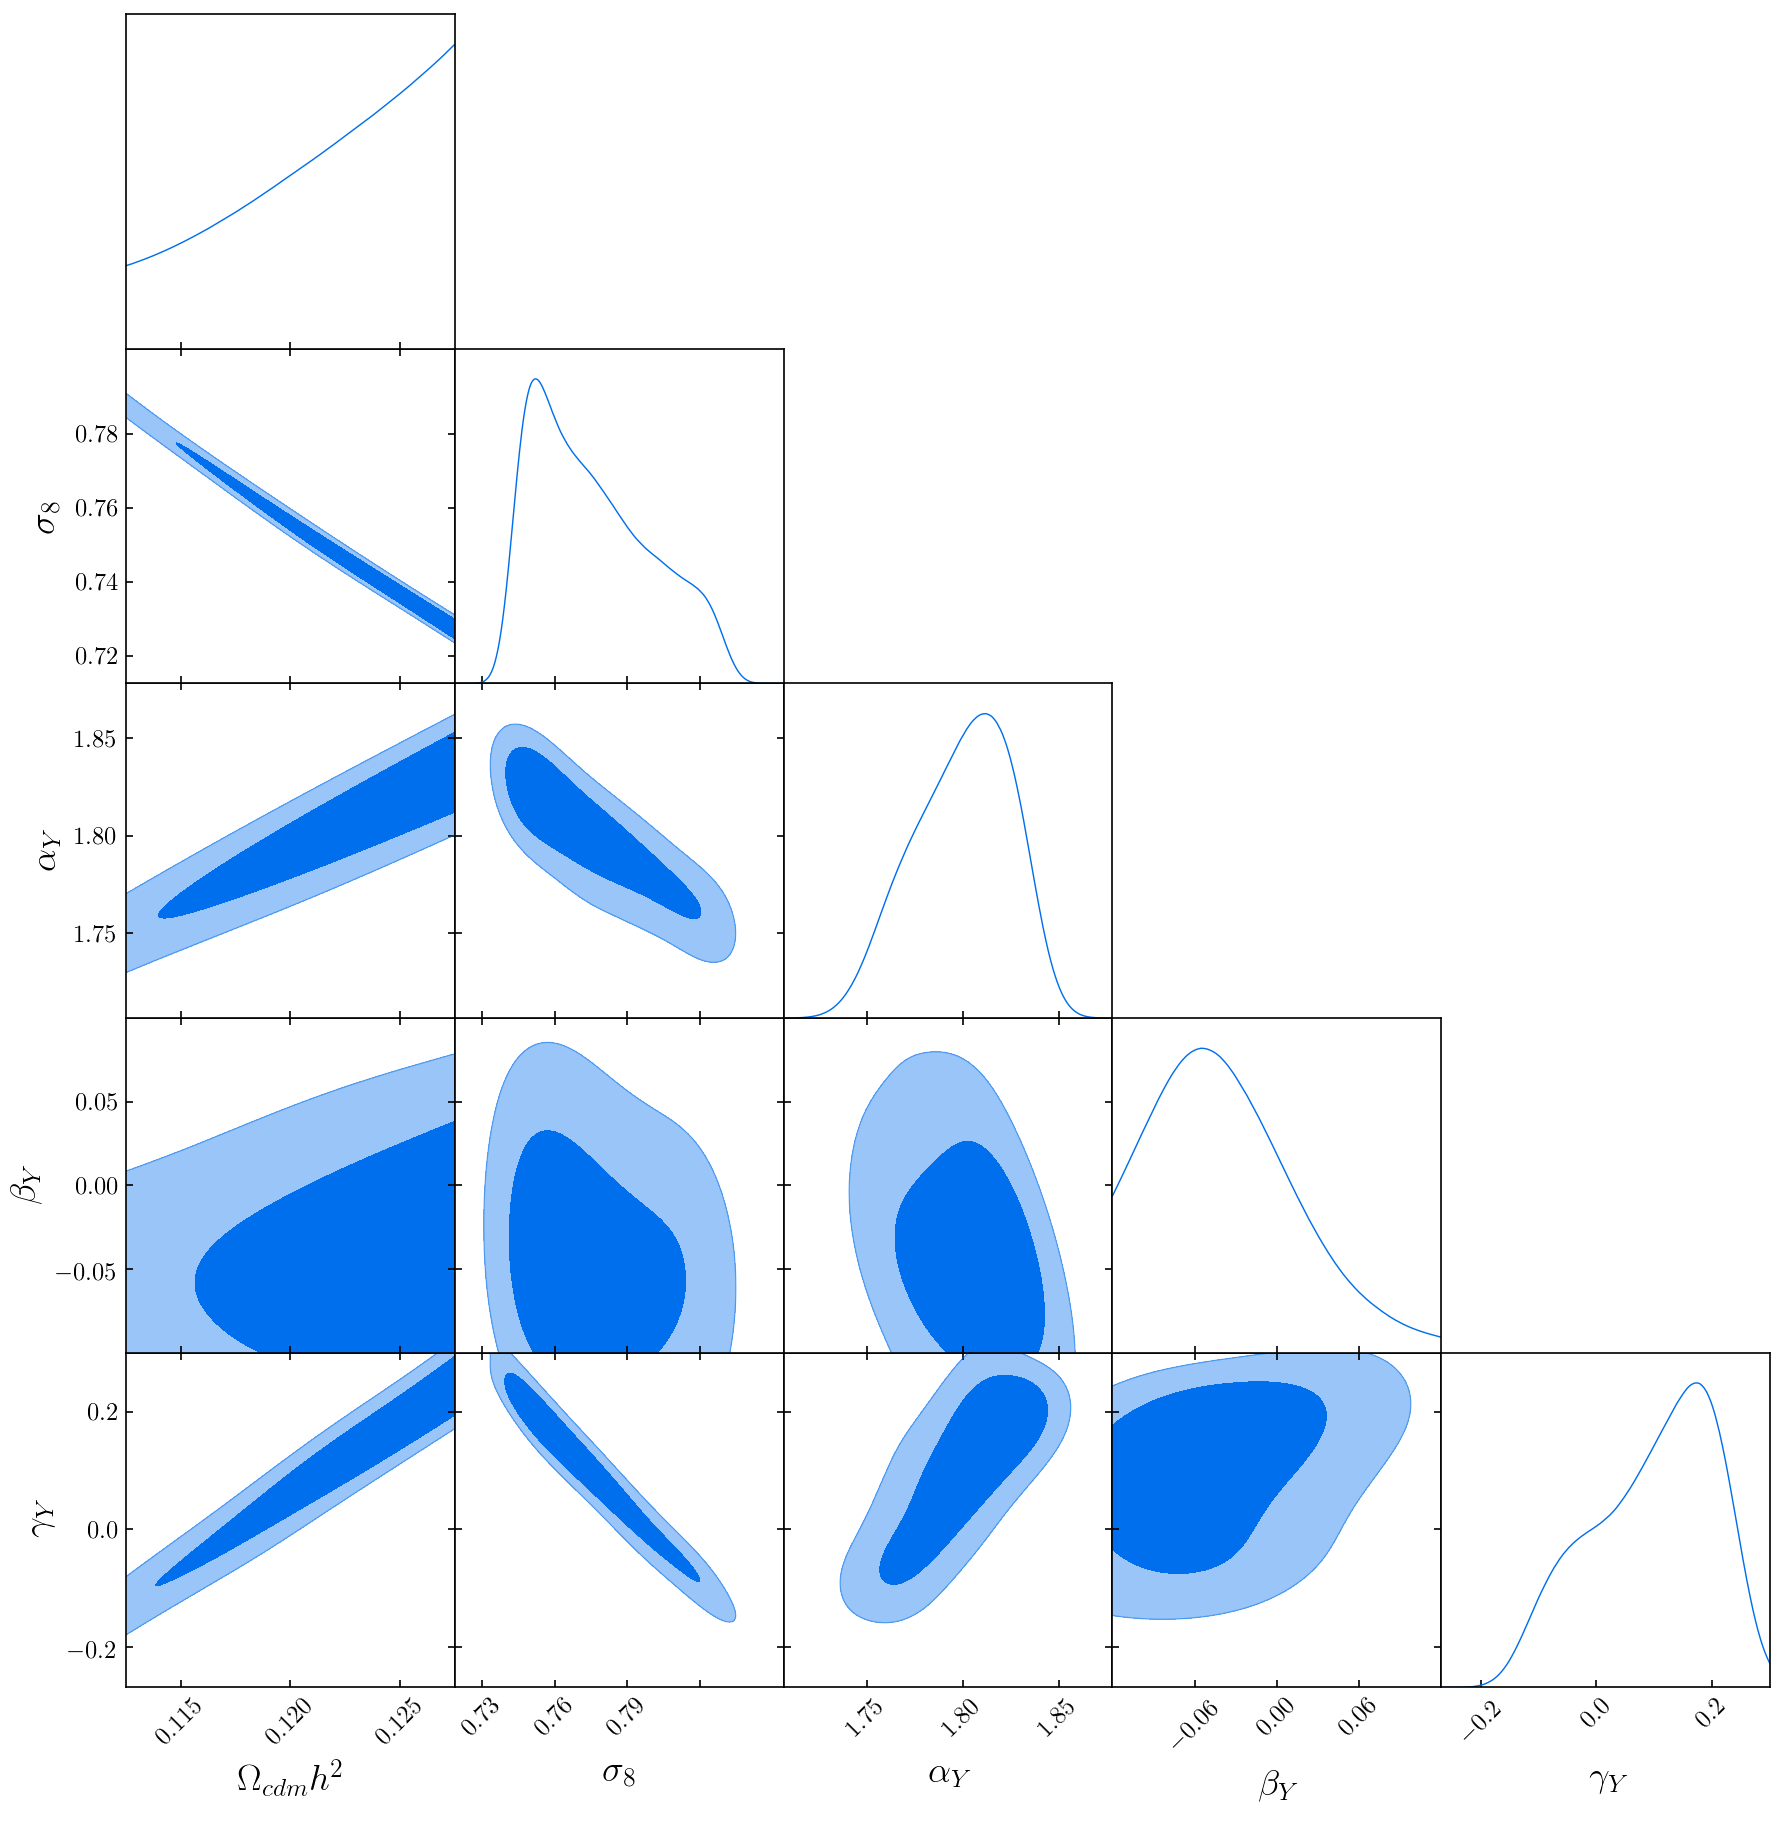

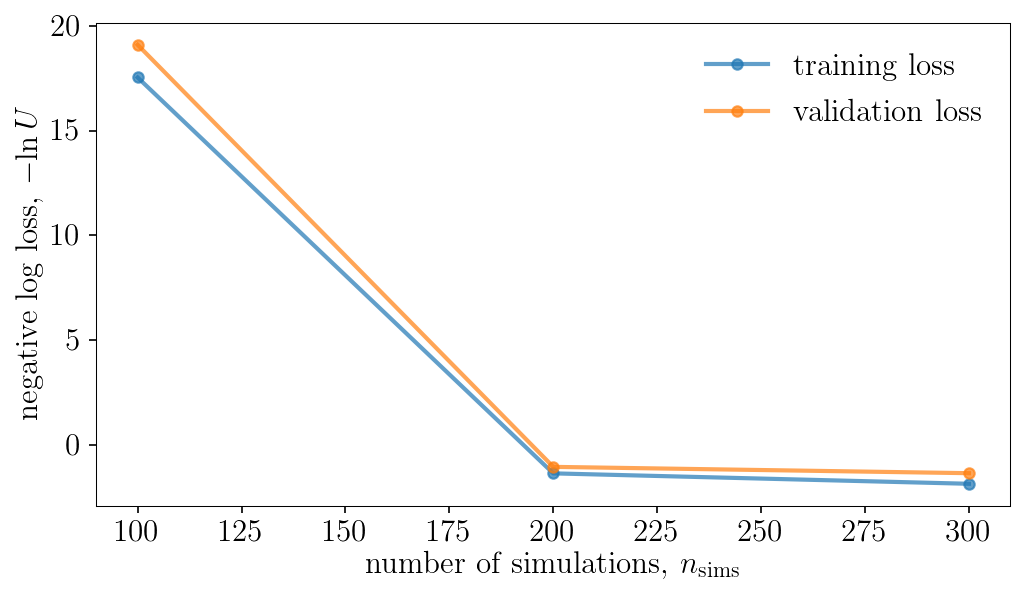

Population 3/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.291735012000572
simulation time: 4.252625973999784
simulation time: 4.284290116999728
simulation time: 4.279188846000579
simulation time: 4.283983100000114
simulation time: 4.282188144999964
simulation time: 4.271451628999785
simulation time: 4.271052682000118
simulation time: 4.249282299000697
simulation time: 4.23698919600065
simulation time: 4.252337455999623
simulation time: 4.272154514000249
simulation time: 4.282087646999571
simulation time: 4.284060328000123
simulation time: 4.284529638999629
simulation time: 4.306255611999404
simulation time: 4.286482878999777
simulation time: 4.2730622400003995
simulation time: 4.277265849000287
simulation time: 4.283173425000314
simulation time: 4.281217710999954
simulation time: 4.289220589999786
simulation time: 4.283896876999279
simulation time: 4.287722895000115
simulation time: 4.27625923100004
simulation time: 4.281776841999999
simulation time: 4.276765042999614
simulation time: 4.270720608999909
simulation time: 4.26

Sampling approximate posterior...
Done.
Removed no burn in


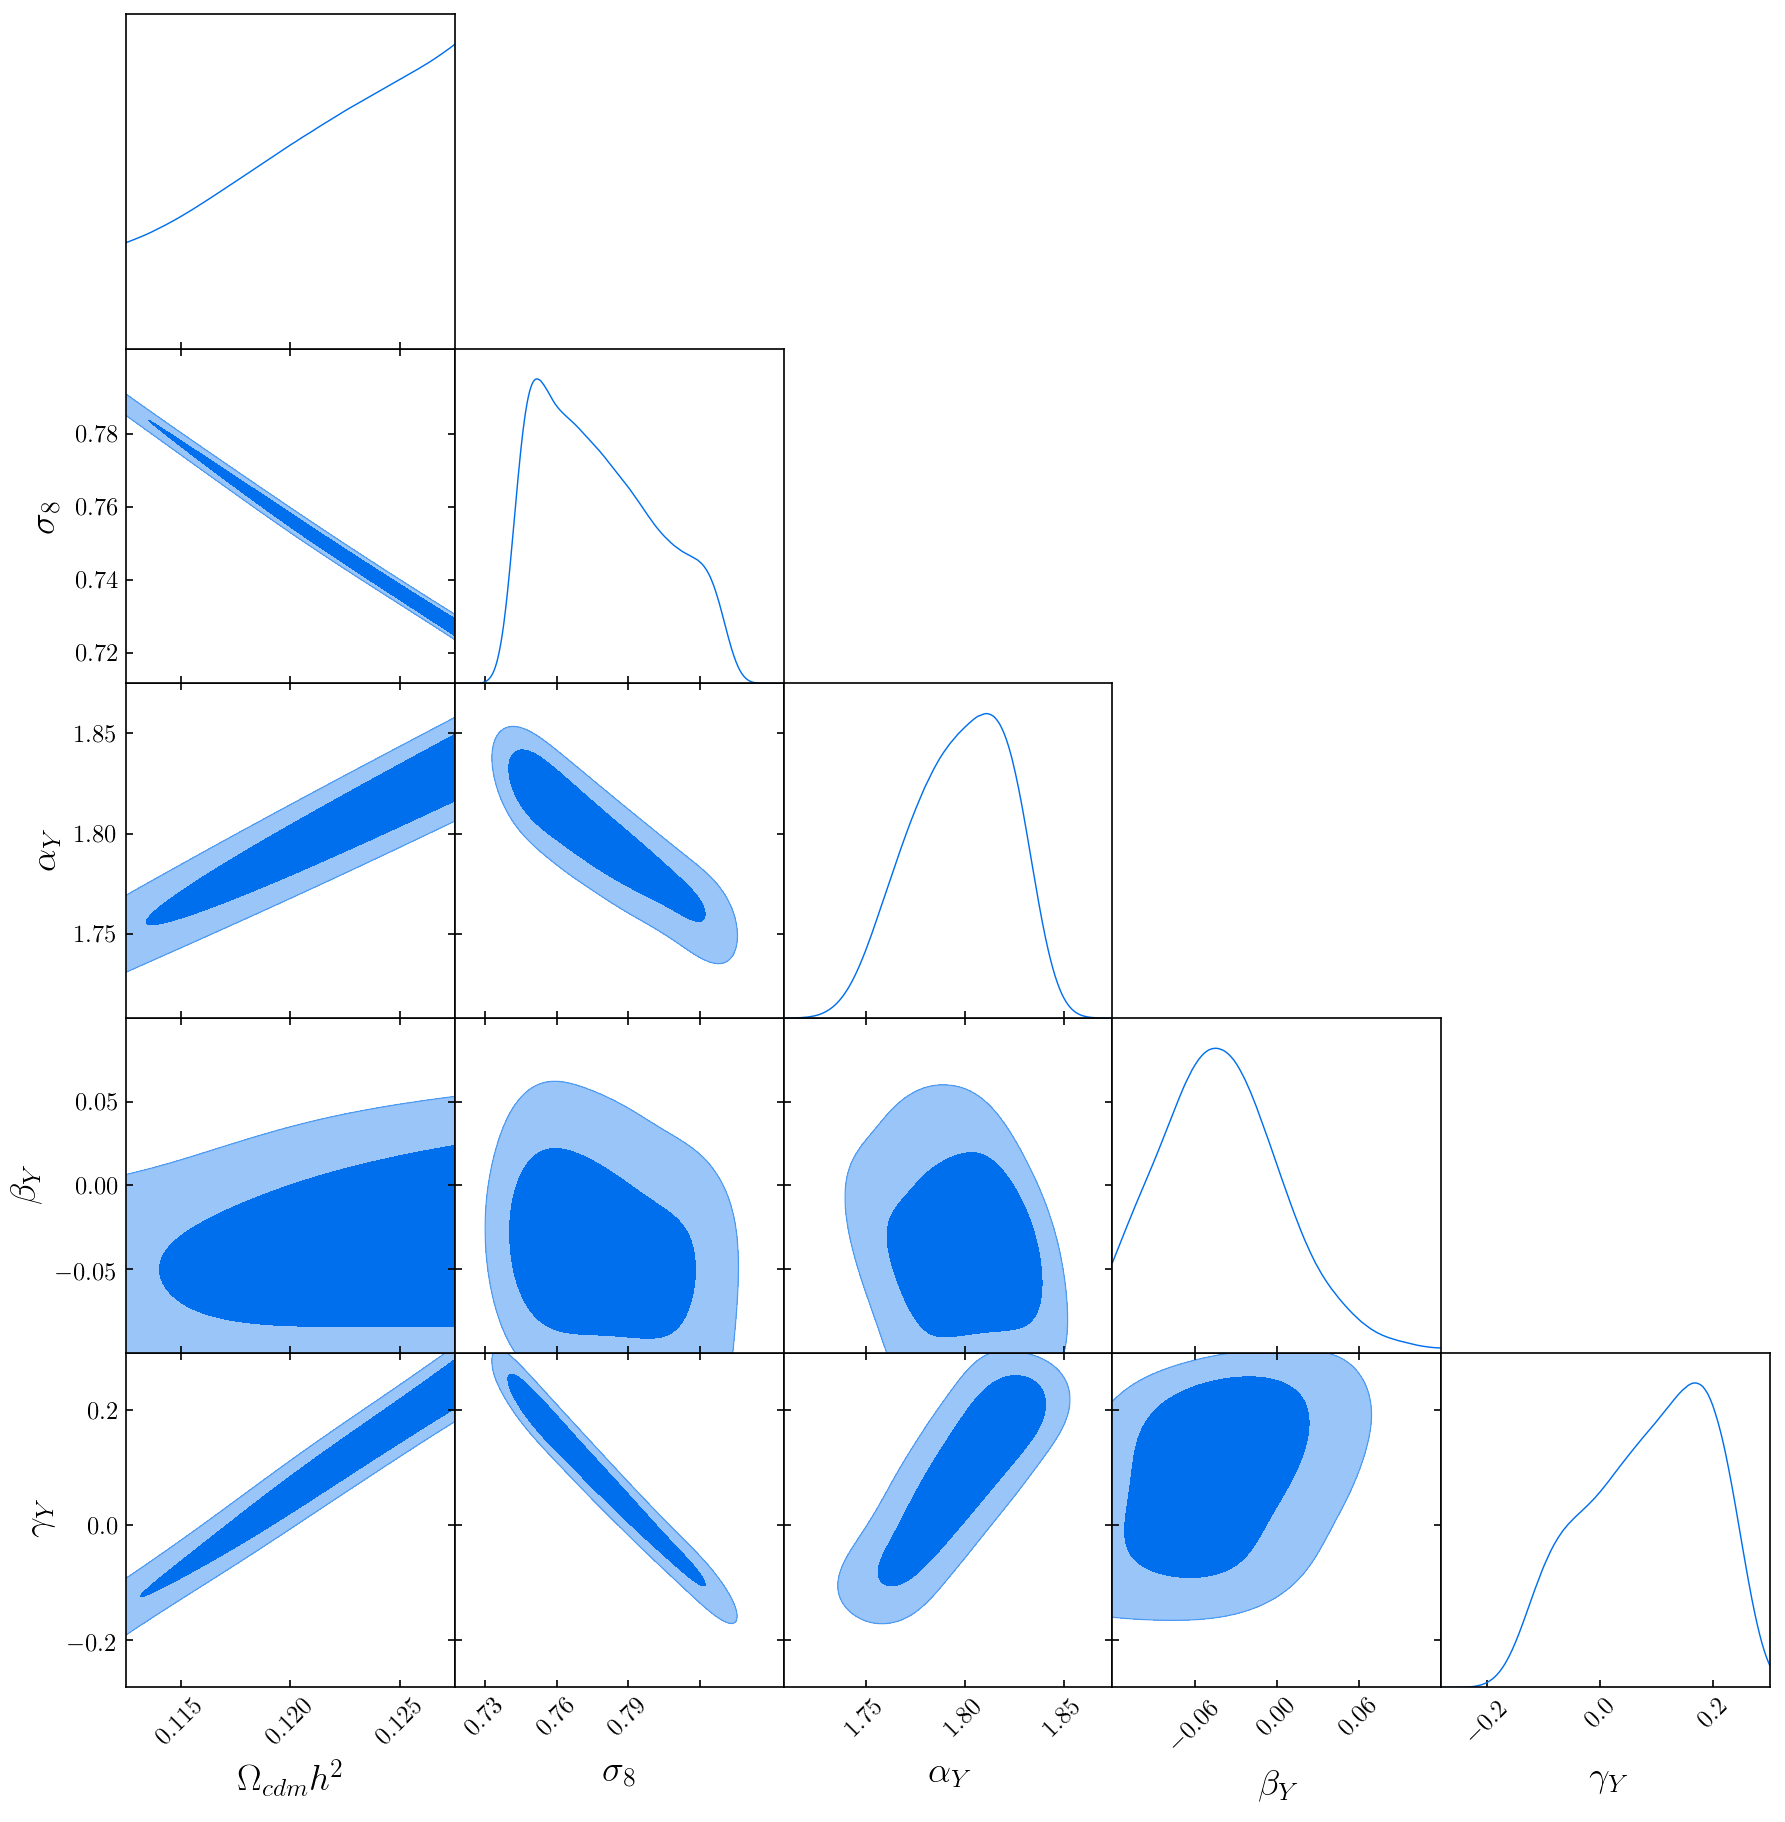

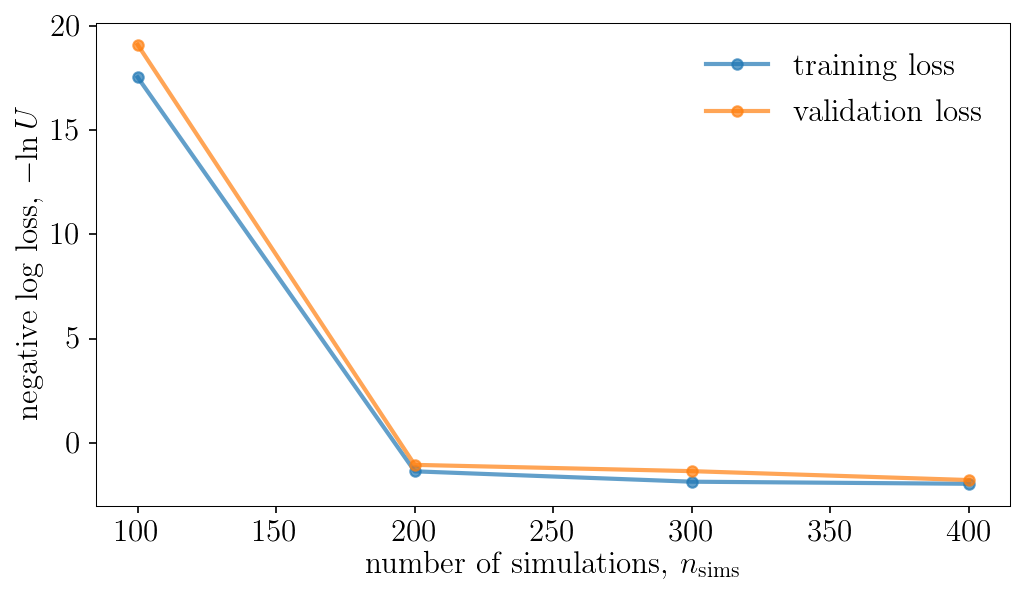

Population 4/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.294071959000576
simulation time: 4.2753523979999954
simulation time: 4.267220339000232
simulation time: 4.268236087000332
simulation time: 4.279097327000272
simulation time: 4.2782819170006405
simulation time: 4.289117651000197
simulation time: 4.266365114000109
simulation time: 4.276708220000728
simulation time: 4.278399520000676
simulation time: 4.271881876999942
simulation time: 4.2827479910001784
simulation time: 4.264001276000272
simulation time: 4.257497521000005
simulation time: 4.23120651499994
simulation time: 4.27207077499952
simulation time: 4.282964517999972
simulation time: 4.230689272999371
simulation time: 4.262698626000201
simulation time: 4.272365411999999
simulation time: 4.282018416000028
simulation time: 4.26605301499967
simulation time: 4.272128009999506
simulation time: 4.263609653000458
simulation time: 4.126437227999304
simulation time: 4.004272241000763
simulation time: 3.976278034999268
simulation time: 4.002804309000567
simulation time: 4.0

Sampling approximate posterior...
Done.
Removed no burn in


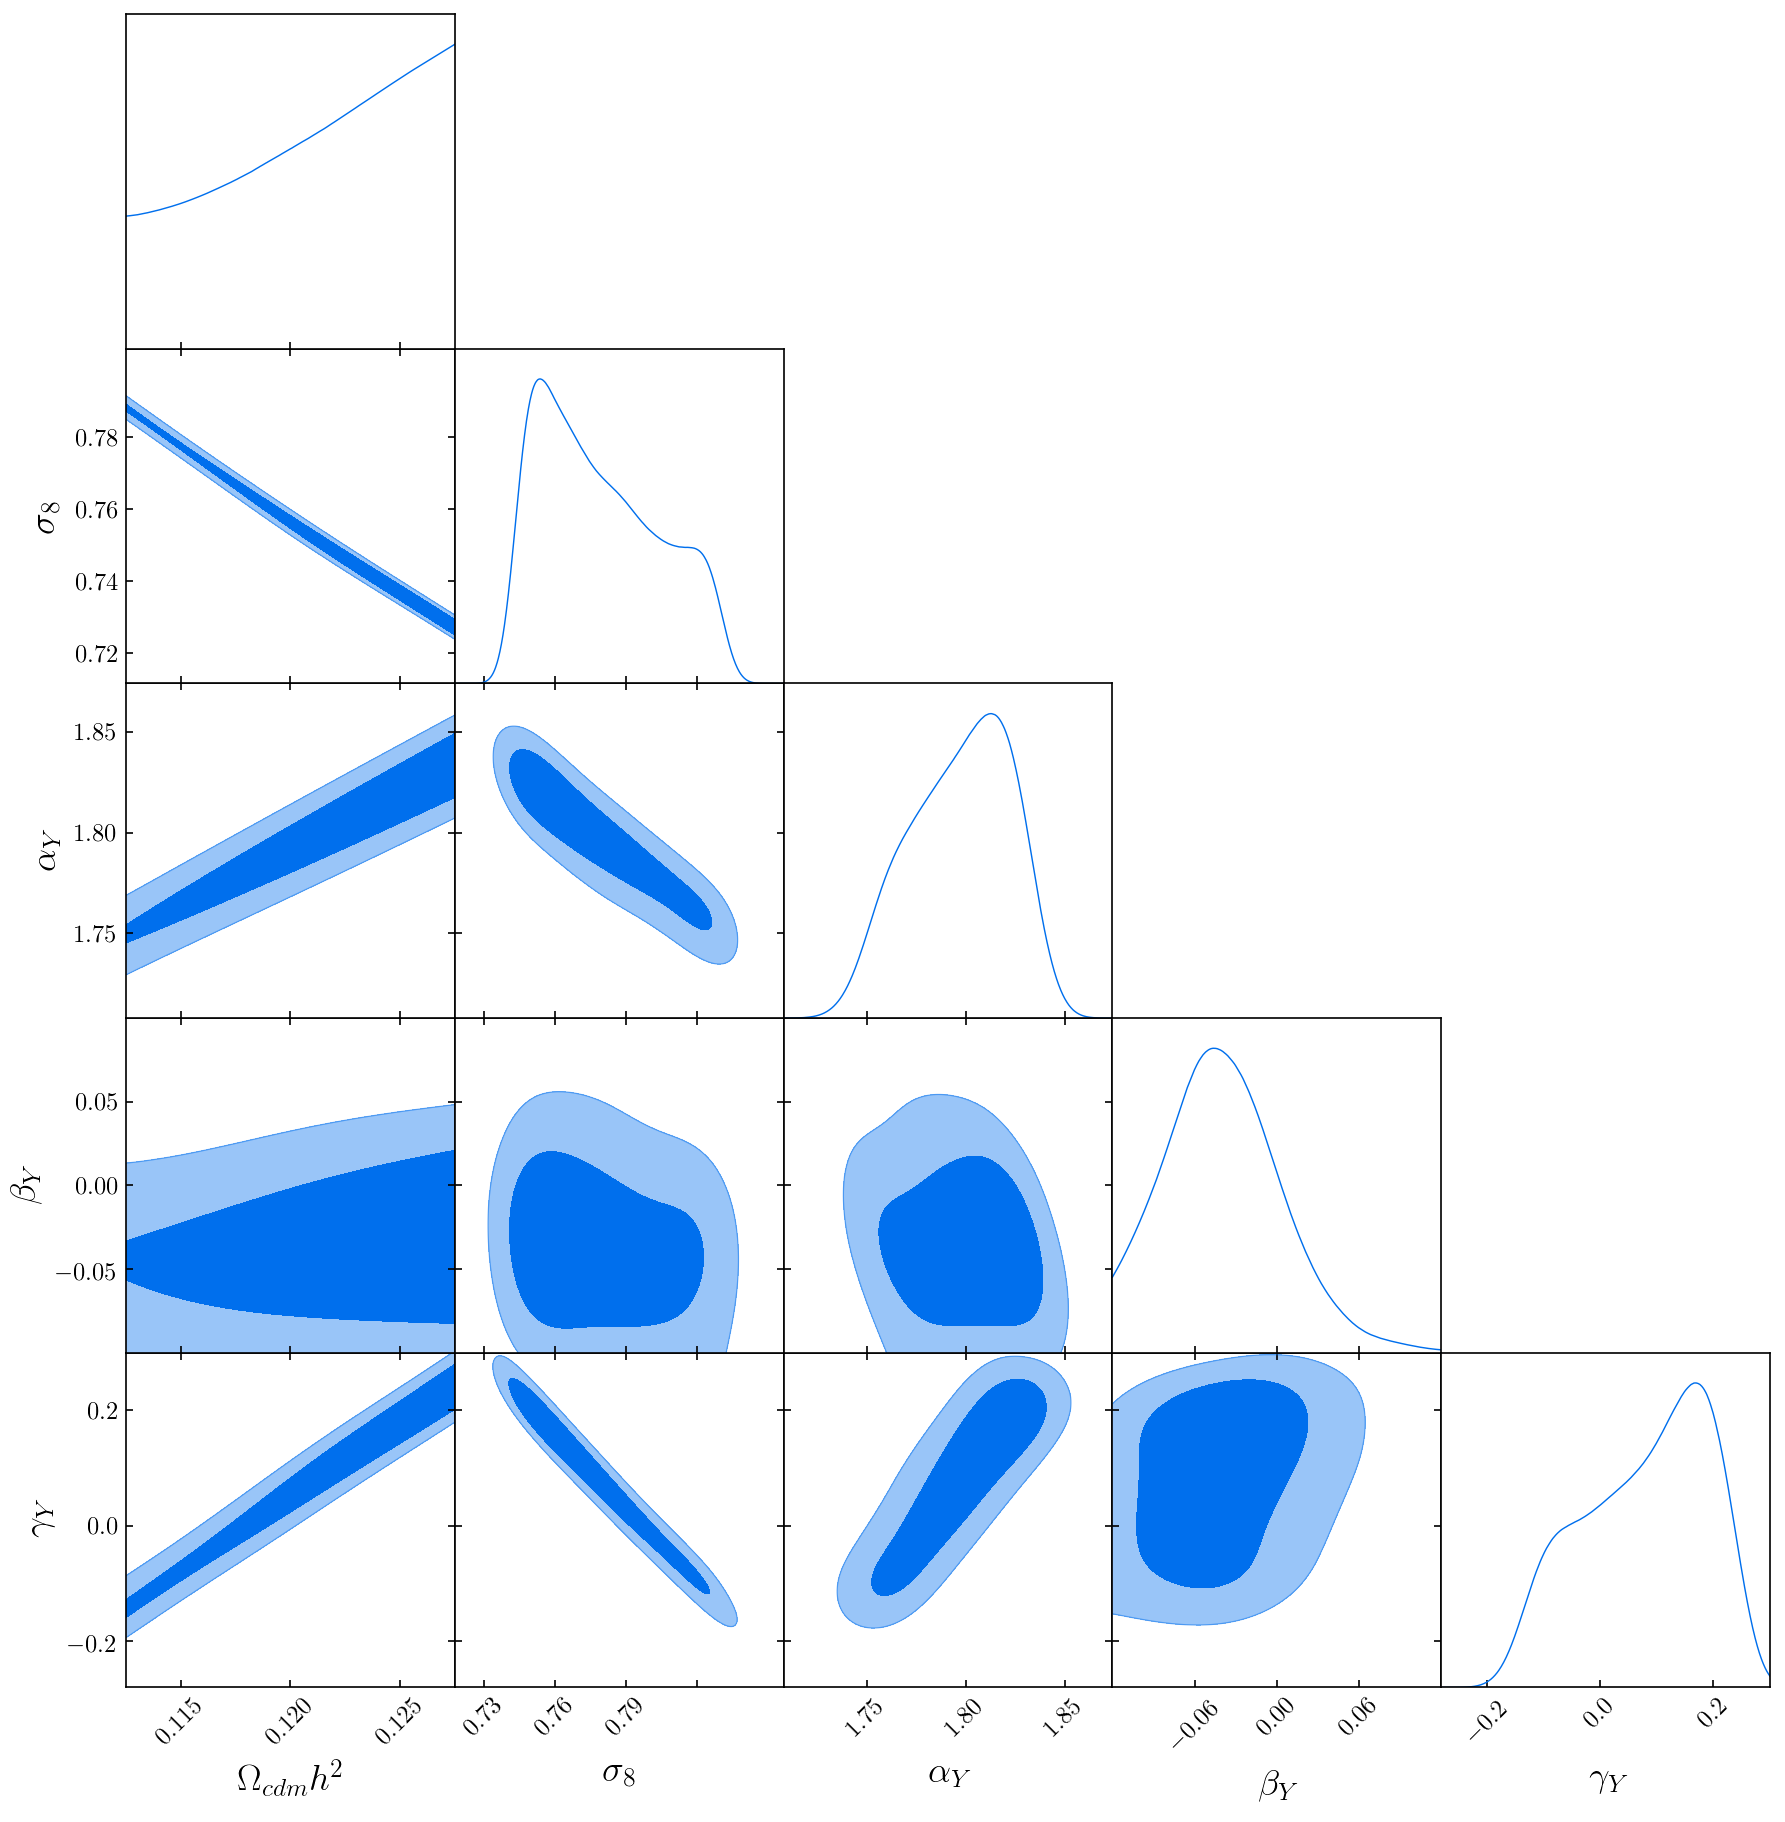

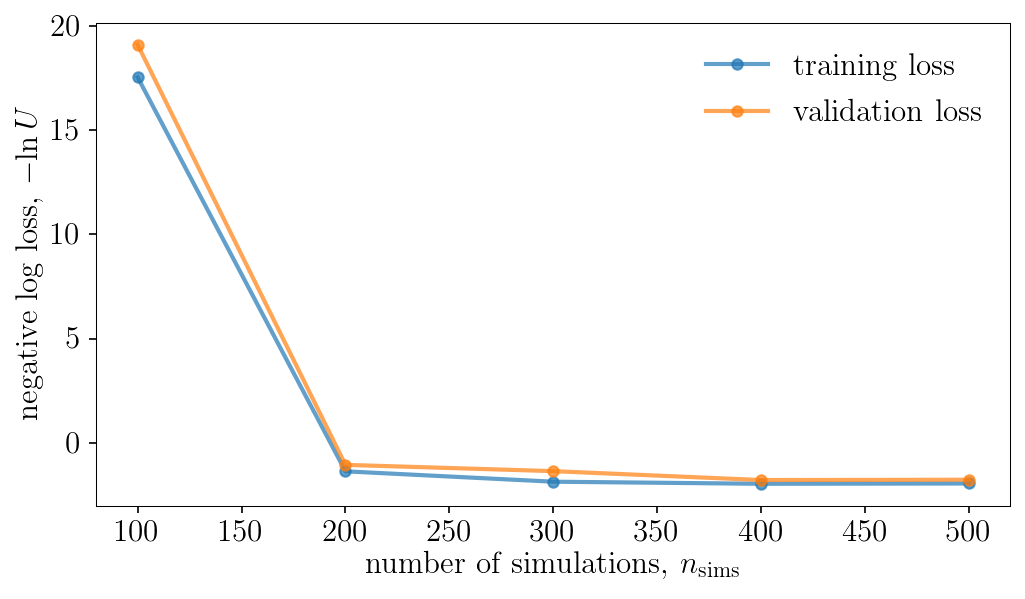

Population 5/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.234615870000198
simulation time: 4.252878490000512
simulation time: 4.215437187999669
simulation time: 4.209987979000289
simulation time: 4.250791501000094
simulation time: 4.232539501000247
simulation time: 4.218173825000122
simulation time: 4.250501862999954
simulation time: 4.234681603000354
simulation time: 4.246304792999581
simulation time: 4.237277571999584
simulation time: 4.2421976409996205
simulation time: 4.217377717999625
simulation time: 4.2276145189998715
simulation time: 4.221343125999738
simulation time: 4.22176933100036
simulation time: 4.2455000589998235
simulation time: 4.205046728000525
simulation time: 4.258971069999461
simulation time: 4.234271548999459
simulation time: 4.221861536999313
simulation time: 4.228008656000384
simulation time: 4.209623792000457
simulation time: 4.231638260000182
simulation time: 4.251970911000171
simulation time: 4.260013396999966
simulation time: 4.243311418999838
simulation time: 4.247934598000029
simulation time: 4

Sampling approximate posterior...
Done.
Removed no burn in


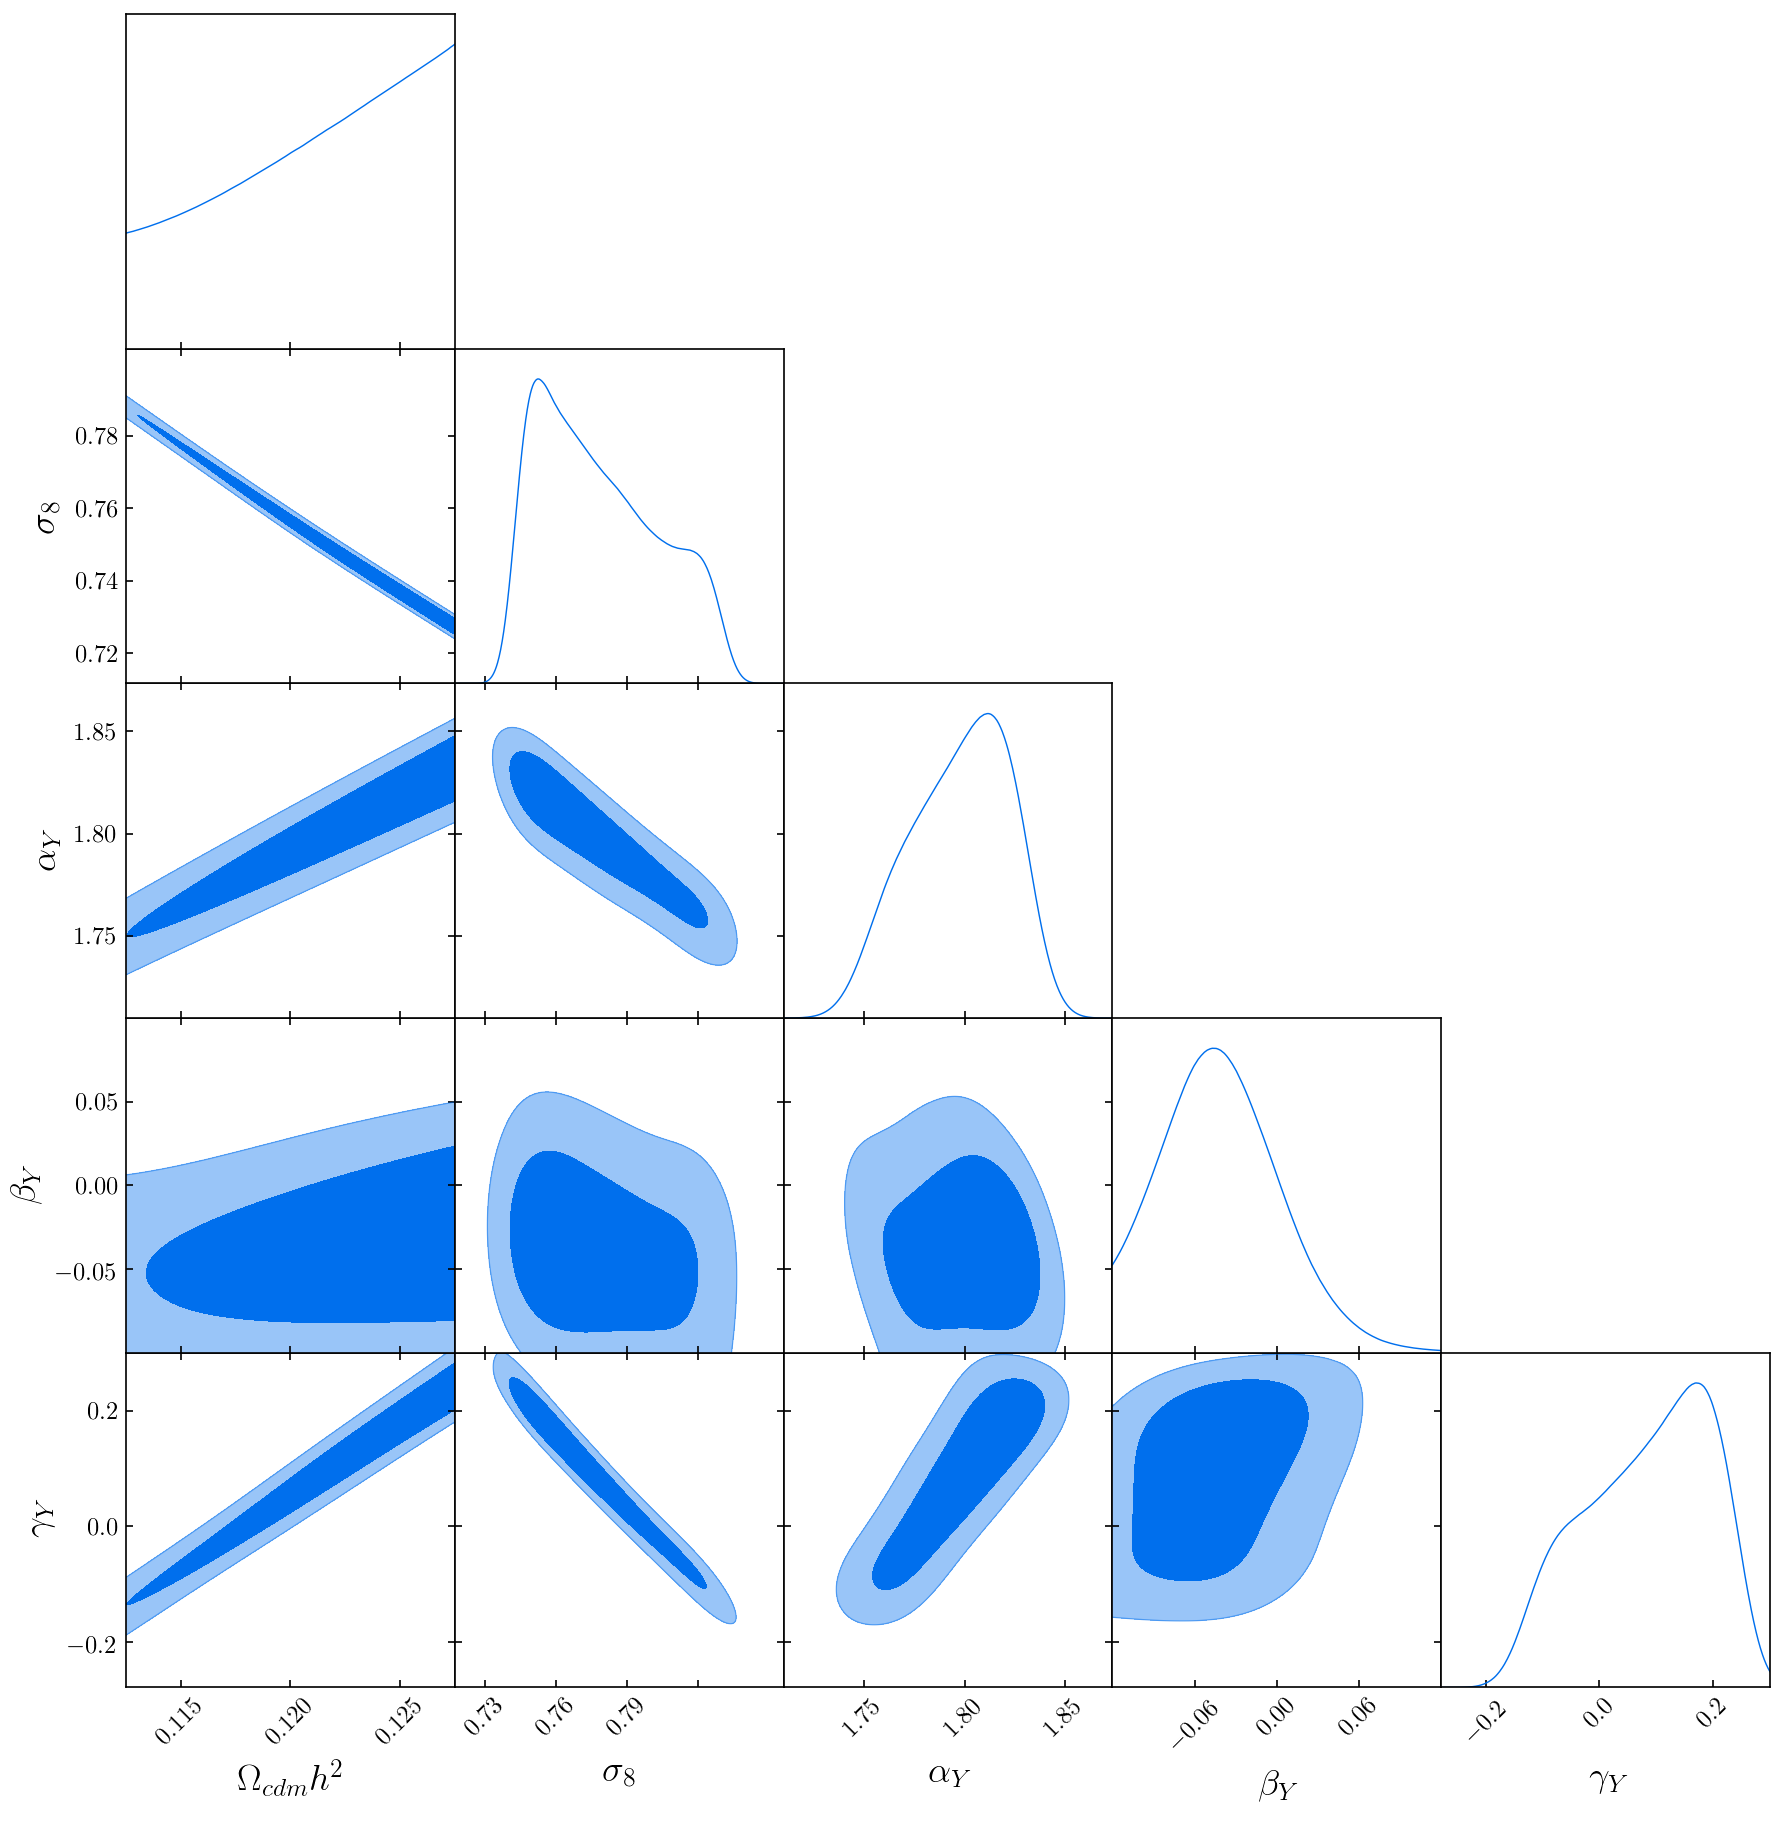

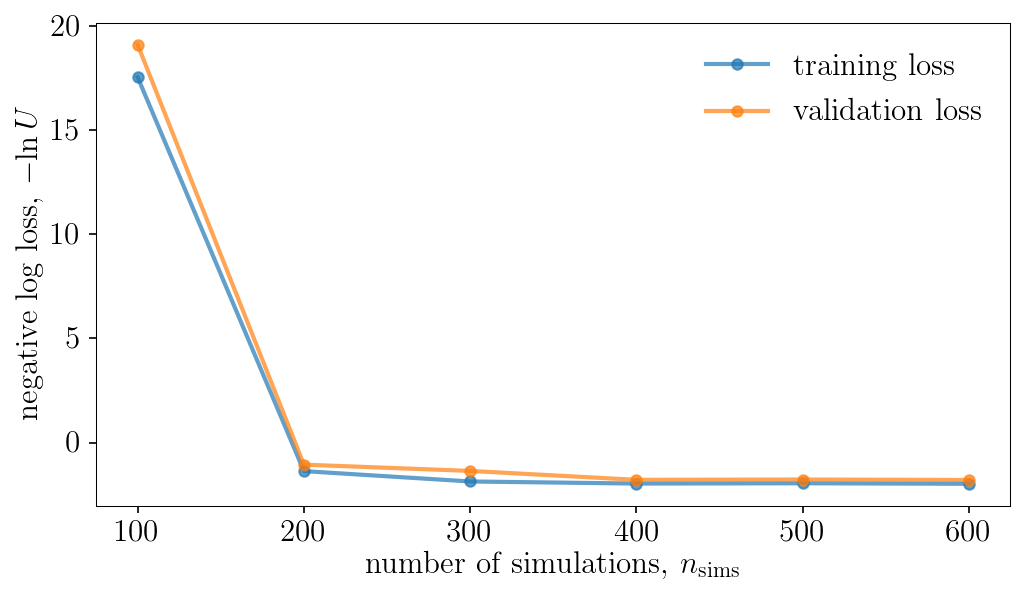

Population 6/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.238790745000188
simulation time: 4.209173797999938
simulation time: 4.2535926499995185
simulation time: 4.212124135000522
simulation time: 4.251555400000143
simulation time: 4.243496494000283
simulation time: 4.240370284000164
simulation time: 4.240342735000013
simulation time: 4.207413223000003
simulation time: 4.237713041999996
simulation time: 4.24350169399986
simulation time: 4.246403341000587
simulation time: 4.2428049509999255
simulation time: 4.245695273999445
simulation time: 4.24027843299973
simulation time: 4.207647645000179
simulation time: 4.240366818000439
simulation time: 4.2357242409998435
simulation time: 4.2359534039997015
simulation time: 4.215216894999685
simulation time: 4.238079609000124
simulation time: 4.238417108000249
simulation time: 4.226314311000351
simulation time: 4.228403308999987
simulation time: 4.219171610000558
simulation time: 4.21095406600034
simulation time: 4.2355565900006695
simulation time: 4.241946231999464
simulation time: 4

Sampling approximate posterior...
Done.
Removed no burn in


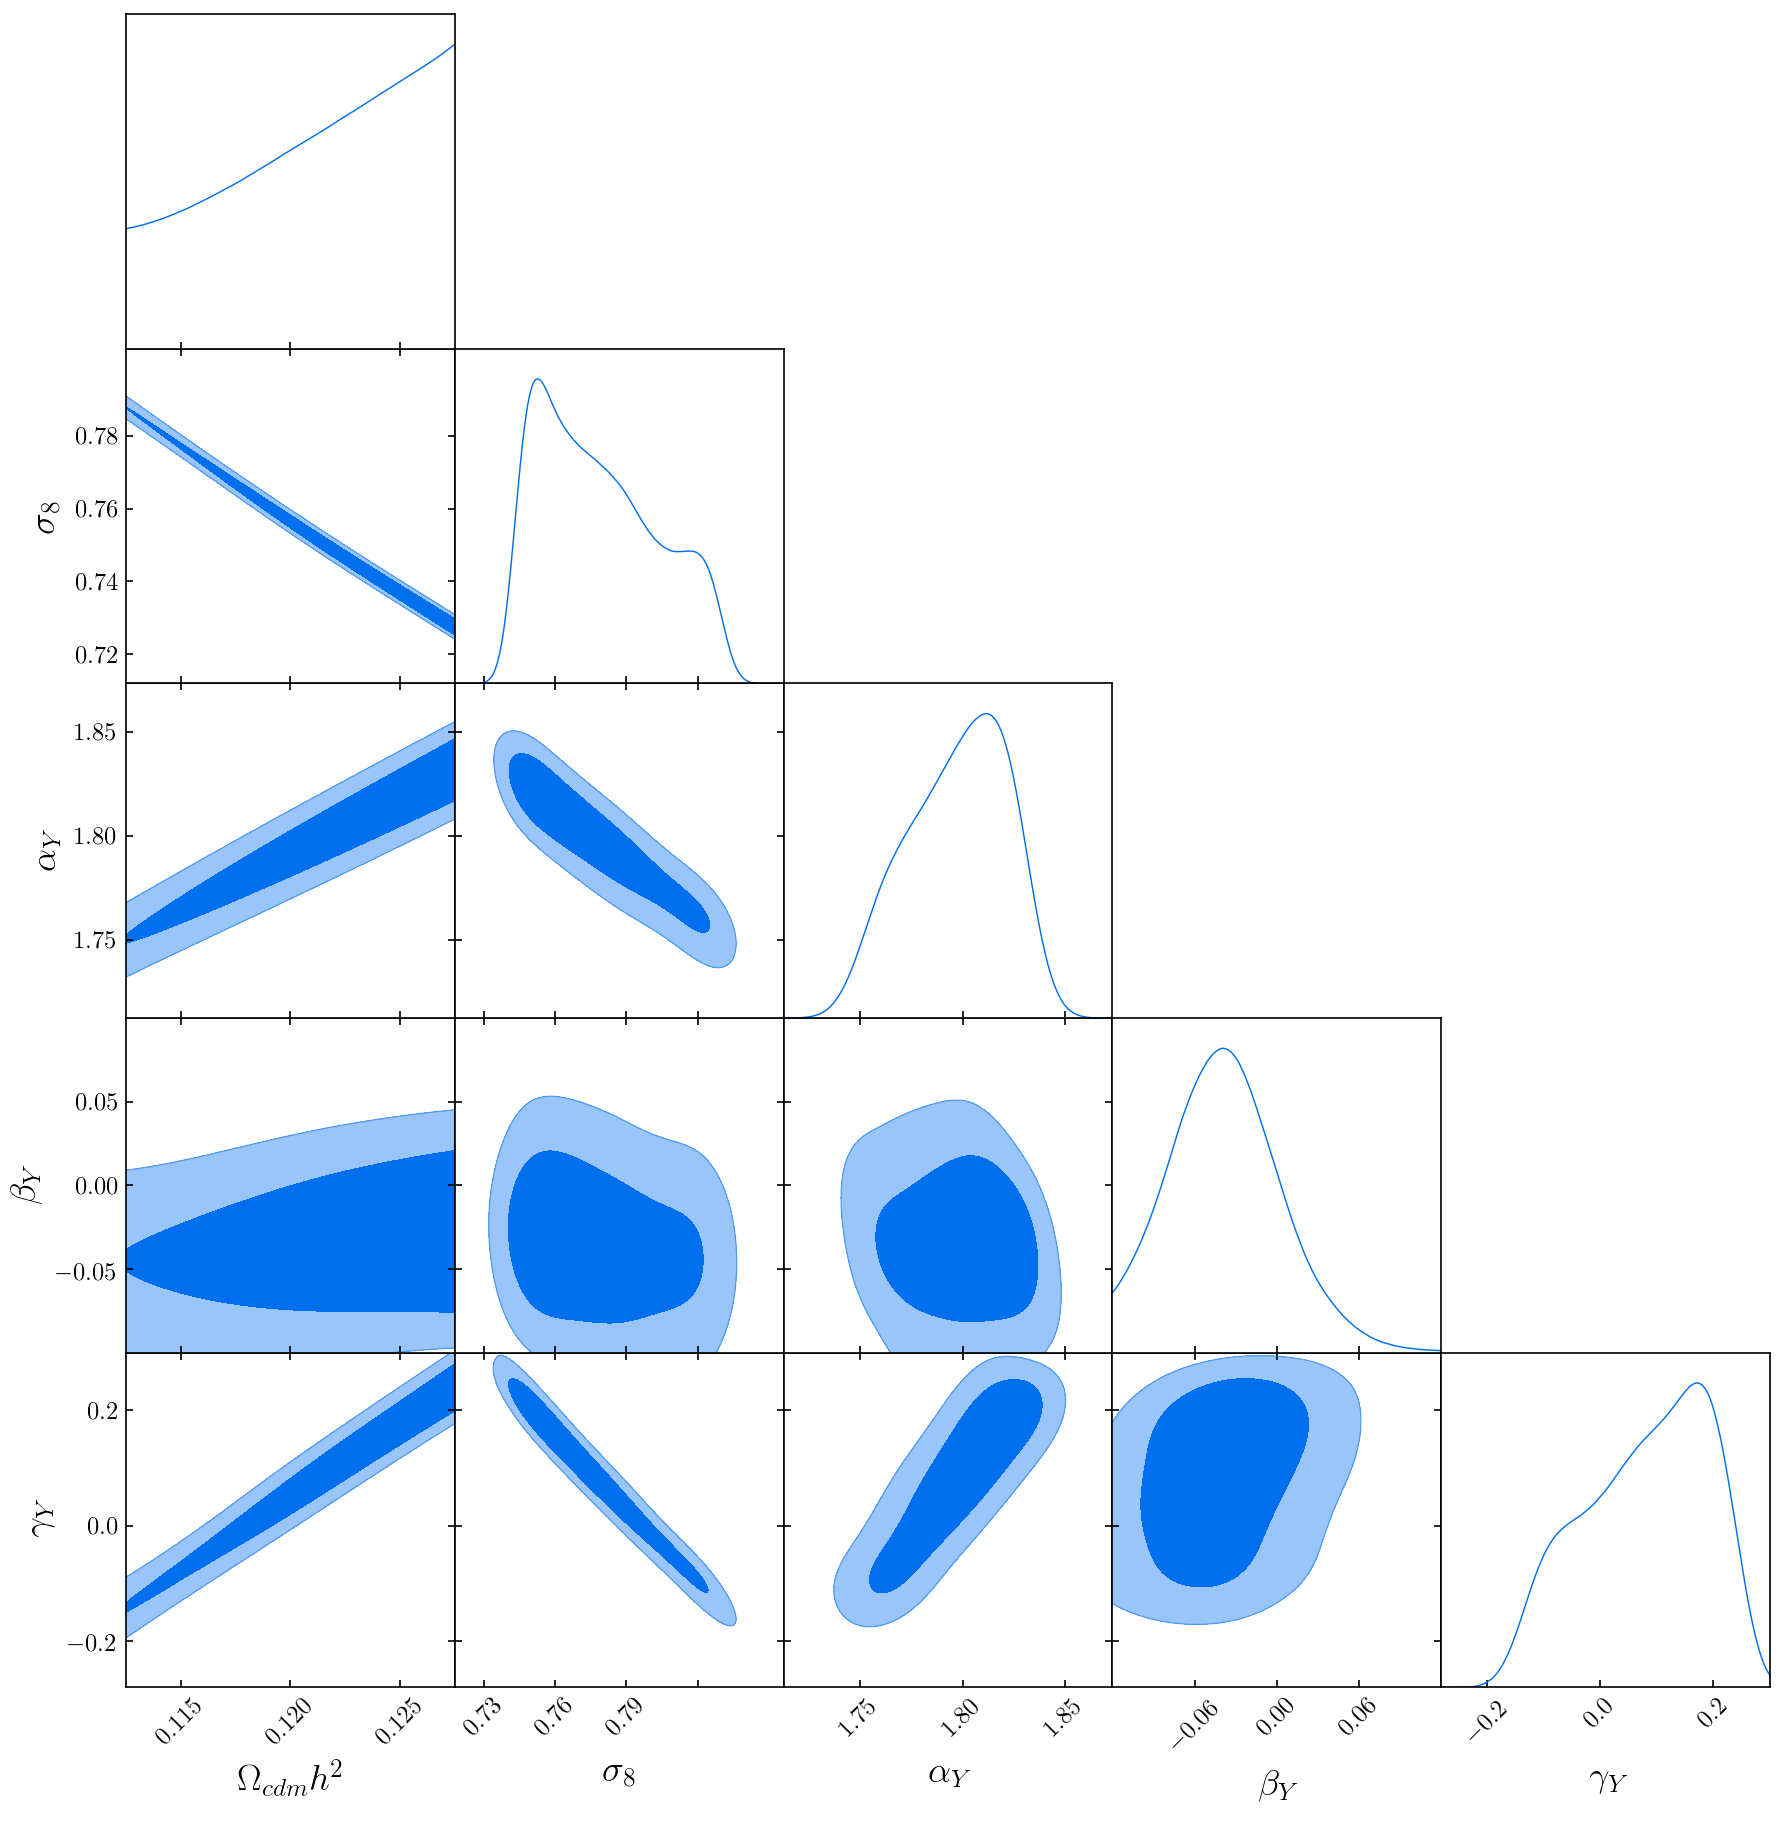

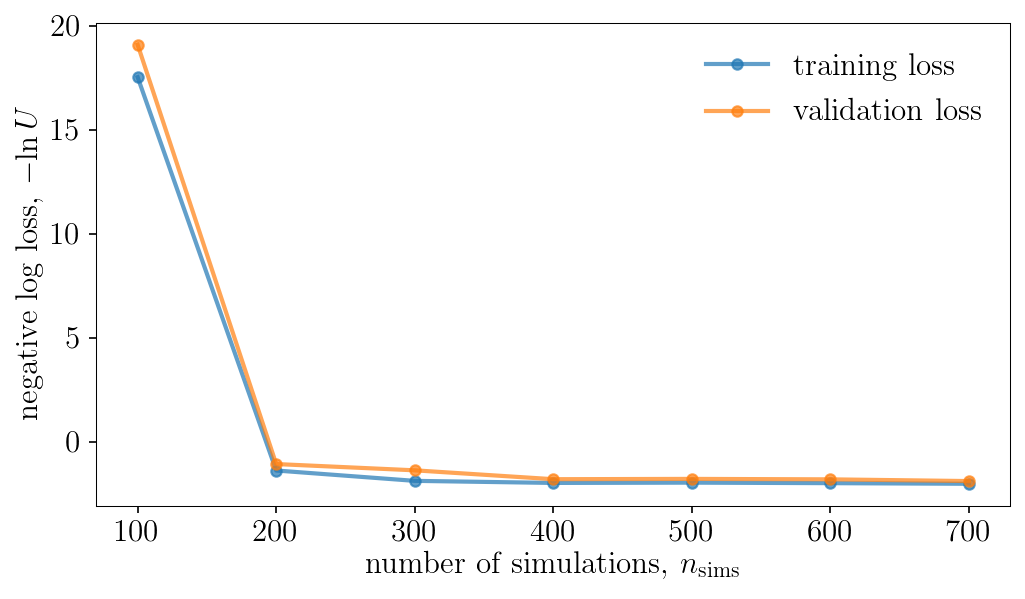

Population 7/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.253458803000285
simulation time: 4.245952735000174
simulation time: 4.249143222000384
simulation time: 4.230956274000164
simulation time: 4.232578205000209
simulation time: 4.238427990000673
simulation time: 4.196481472000414
simulation time: 4.211192861999734
simulation time: 4.2590157609993184
simulation time: 4.242455440999947
simulation time: 4.2376298409999436
simulation time: 4.226387201000762
simulation time: 4.212767050999901
simulation time: 4.227611760999935
simulation time: 4.254366657999526
simulation time: 4.257031172000097
simulation time: 4.262847720000536
simulation time: 4.234998190000624
simulation time: 4.190484096999171
simulation time: 4.242984305999926
simulation time: 4.233547353000176
simulation time: 4.1933309369997005
simulation time: 4.230527179000092
simulation time: 4.243824592999772
simulation time: 4.23506446600004
simulation time: 4.244350909999412
simulation time: 4.26039509399925
simulation time: 4.23965914099972
simulation time: 4.2

Sampling approximate posterior...
Done.
Removed no burn in


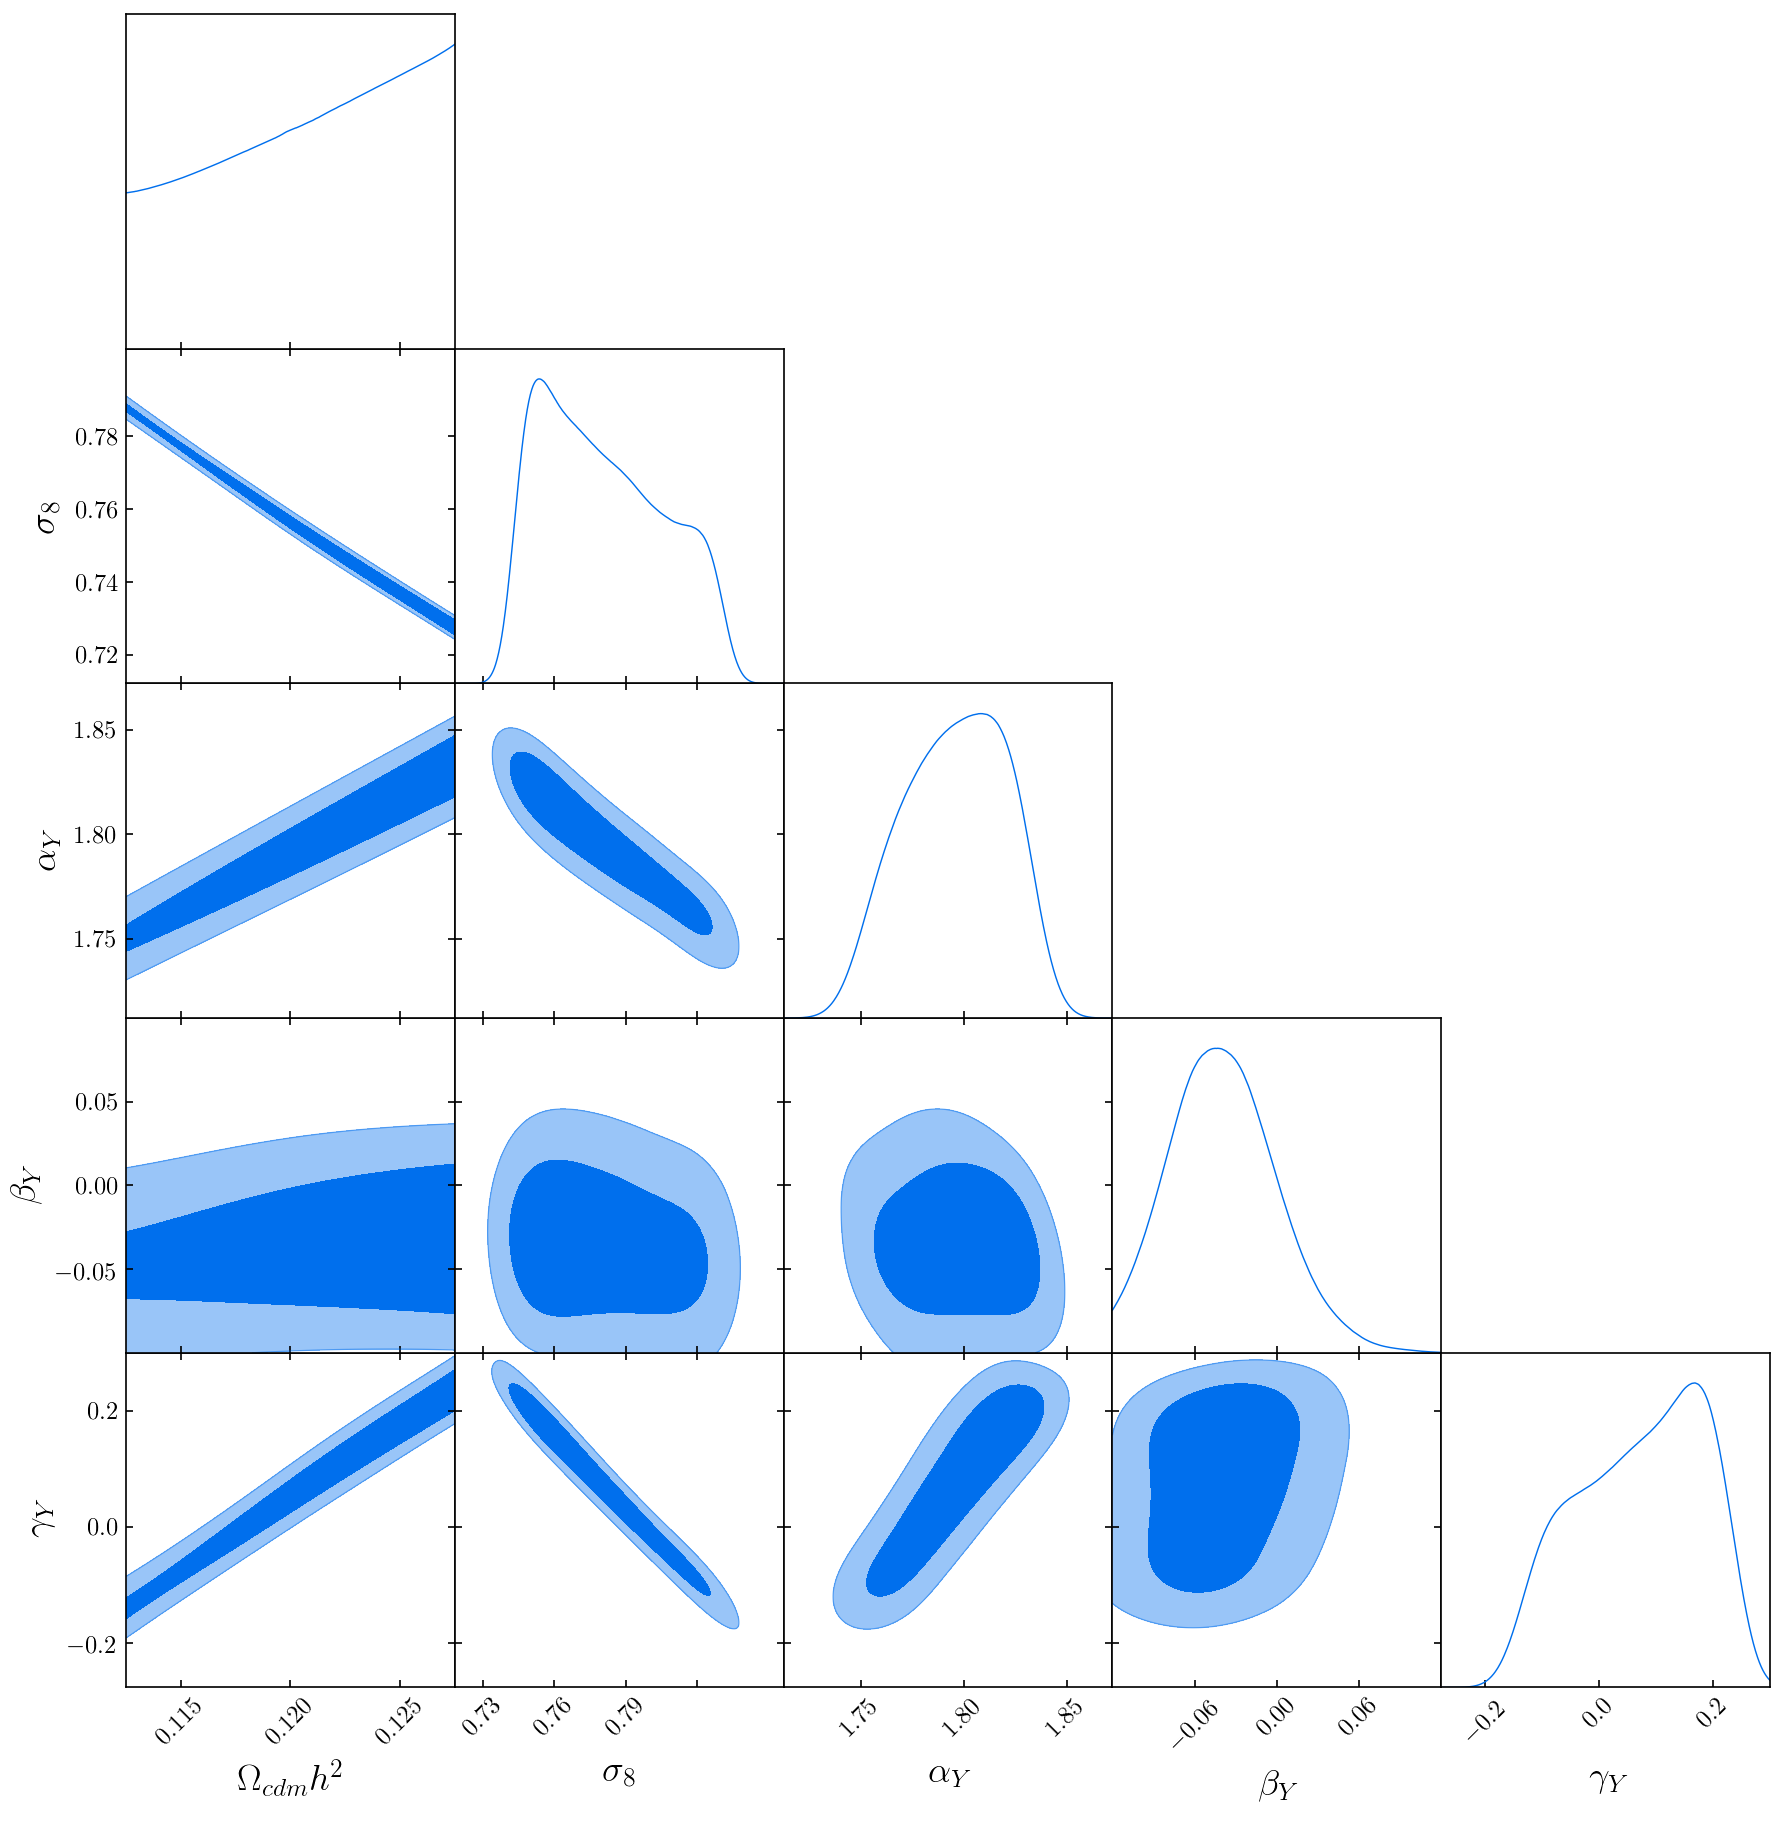

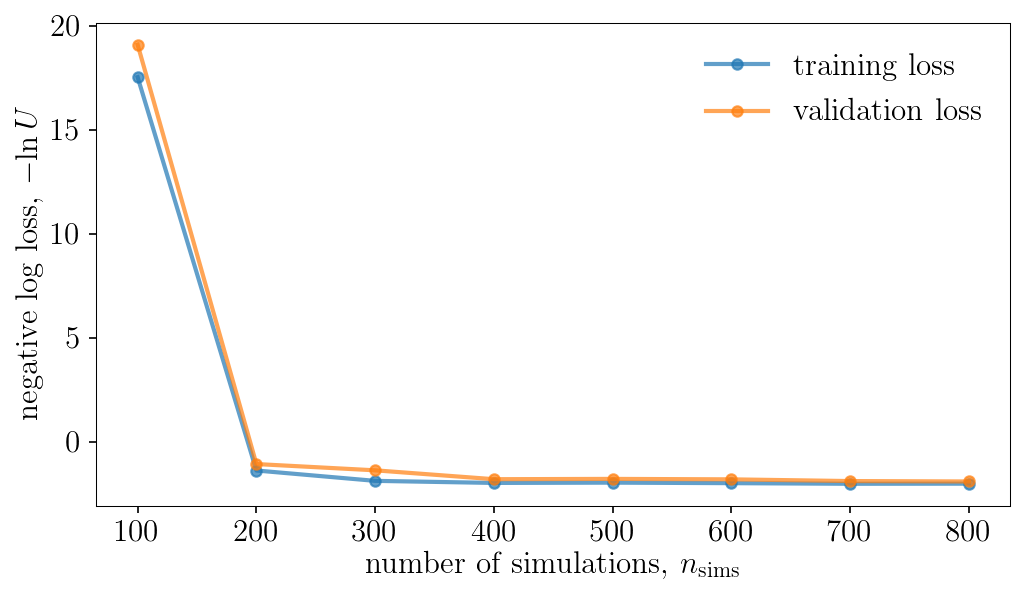

Population 8/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.23980068900164
simulation time: 4.229371739998896
simulation time: 4.2232399889999215
simulation time: 4.208606717998919
simulation time: 4.242488914000205
simulation time: 4.231464307000351
simulation time: 4.226860116999887
simulation time: 4.24261142099931
simulation time: 4.2306106369997
simulation time: 4.21911091200127
simulation time: 4.238307456000257
simulation time: 4.222161019999476
simulation time: 4.238880312999754
simulation time: 4.2420468740001525
simulation time: 4.226801299999352
simulation time: 4.234810562998973
simulation time: 4.246512294999775
simulation time: 4.238259468000251
simulation time: 4.2362818509991484
simulation time: 4.242644519999885
simulation time: 4.2348642380002275
simulation time: 4.227153511001234
simulation time: 4.202235384000232
simulation time: 4.235916030000226
simulation time: 4.223335044000123
simulation time: 4.234621124998739
simulation time: 4.2318937569998525
simulation time: 4.215283368999735
simulation time: 4.2

Sampling approximate posterior...
Done.
Removed no burn in


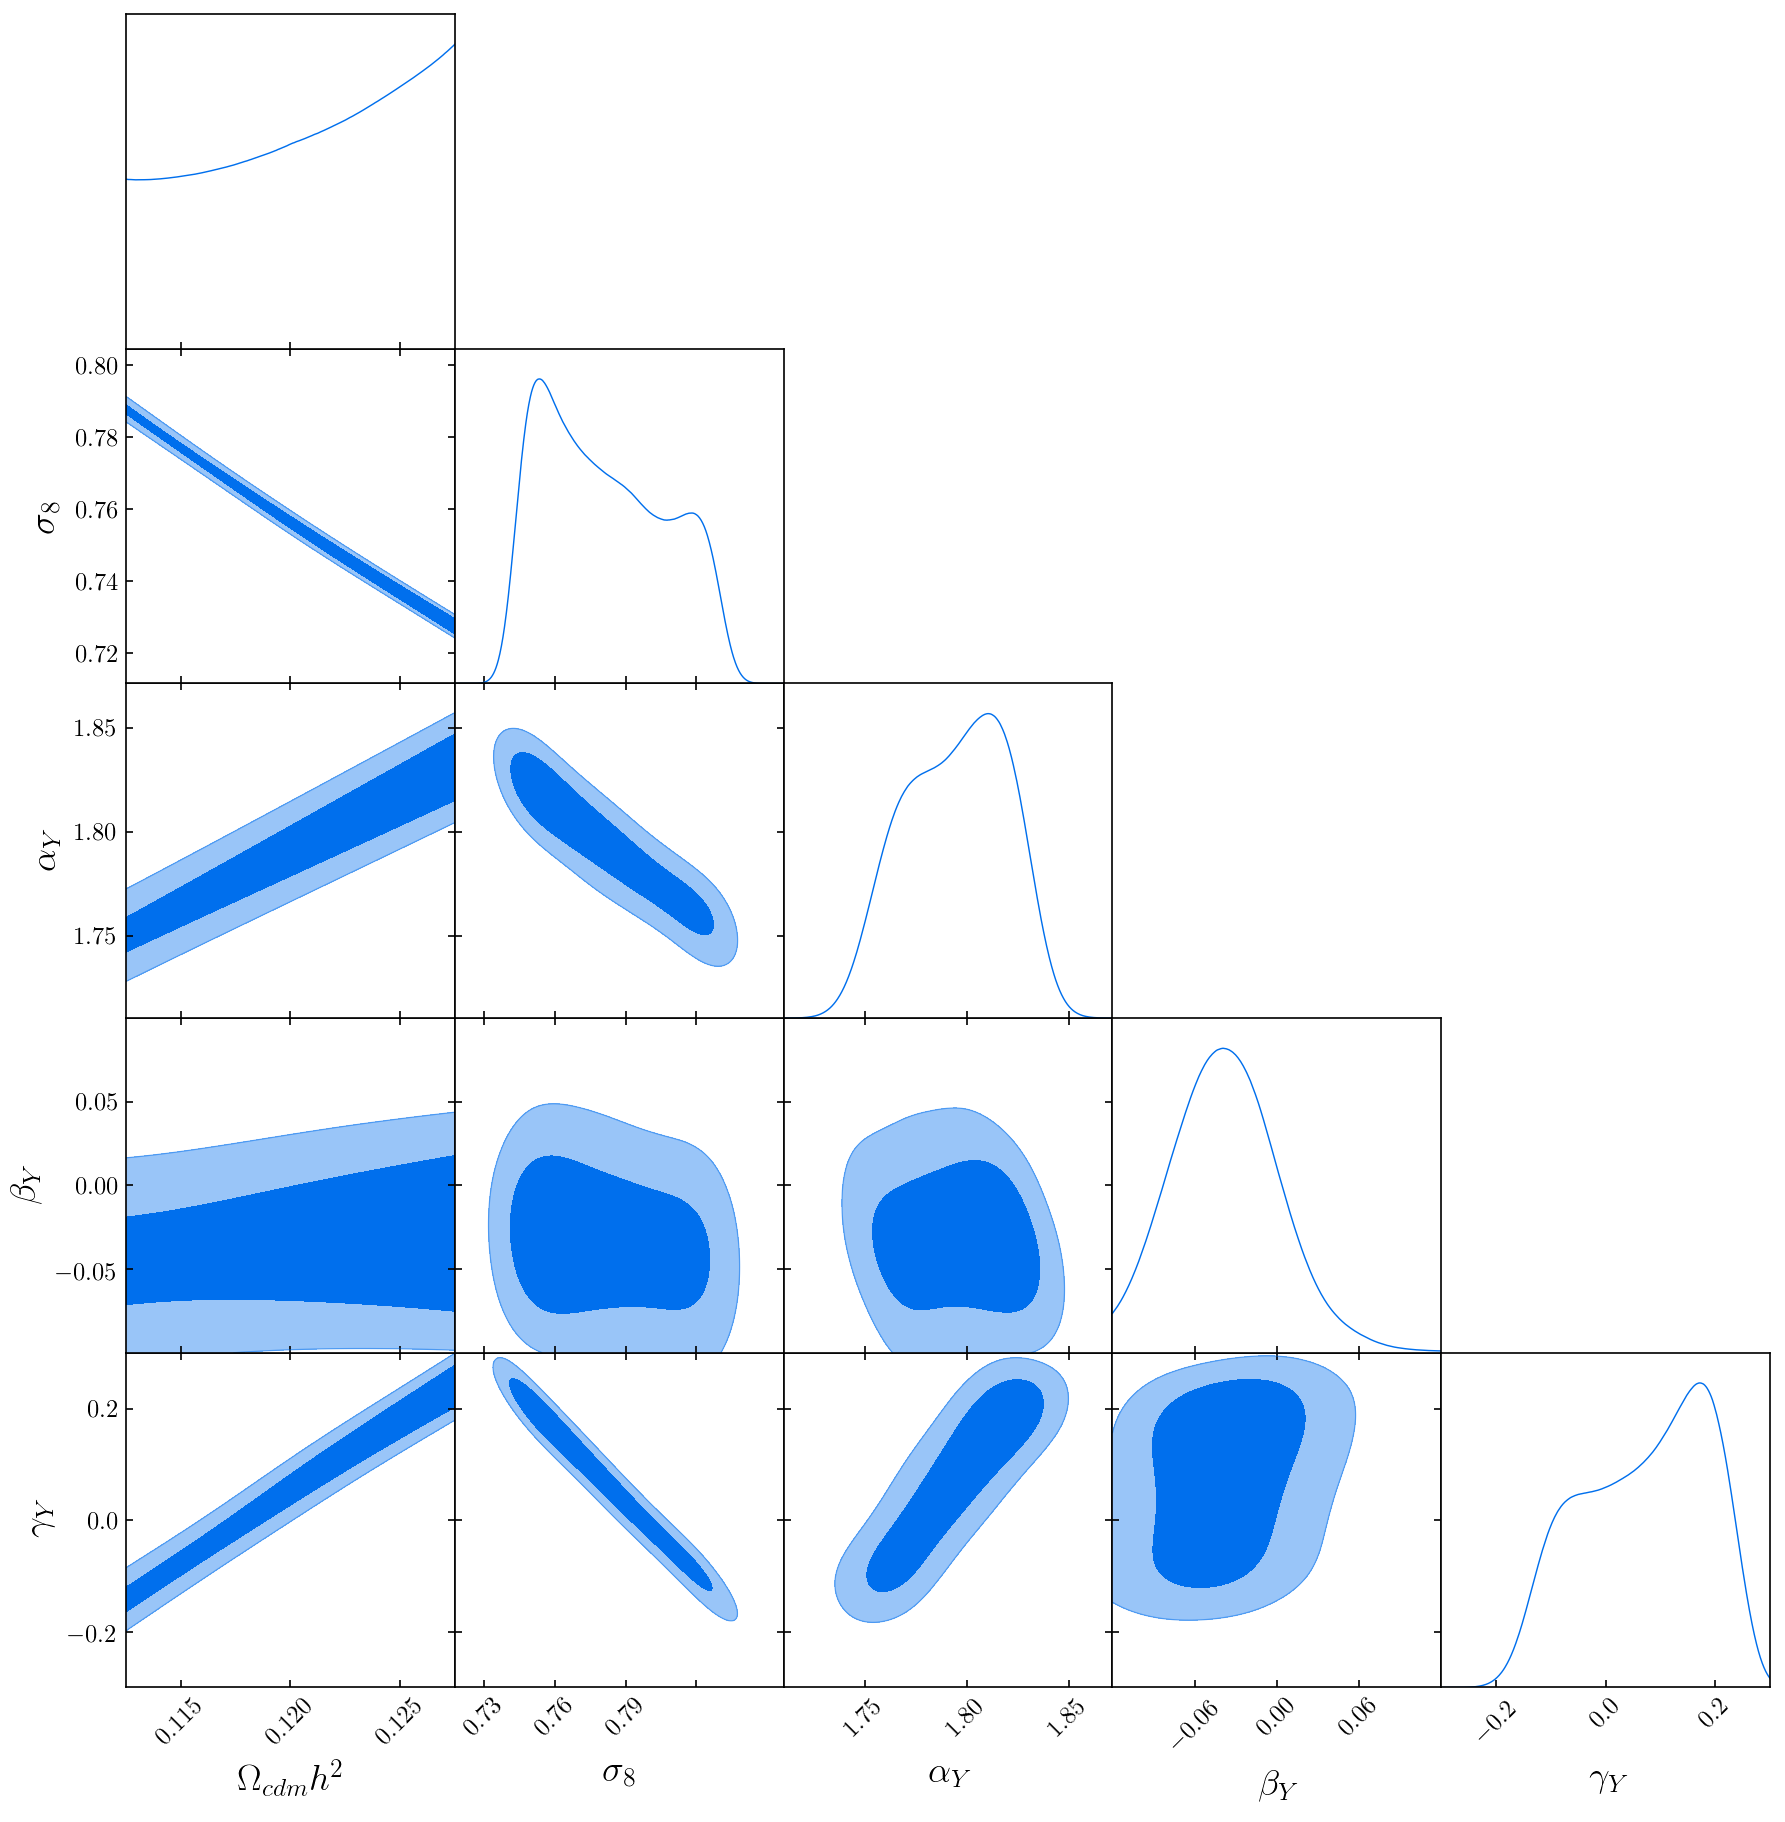

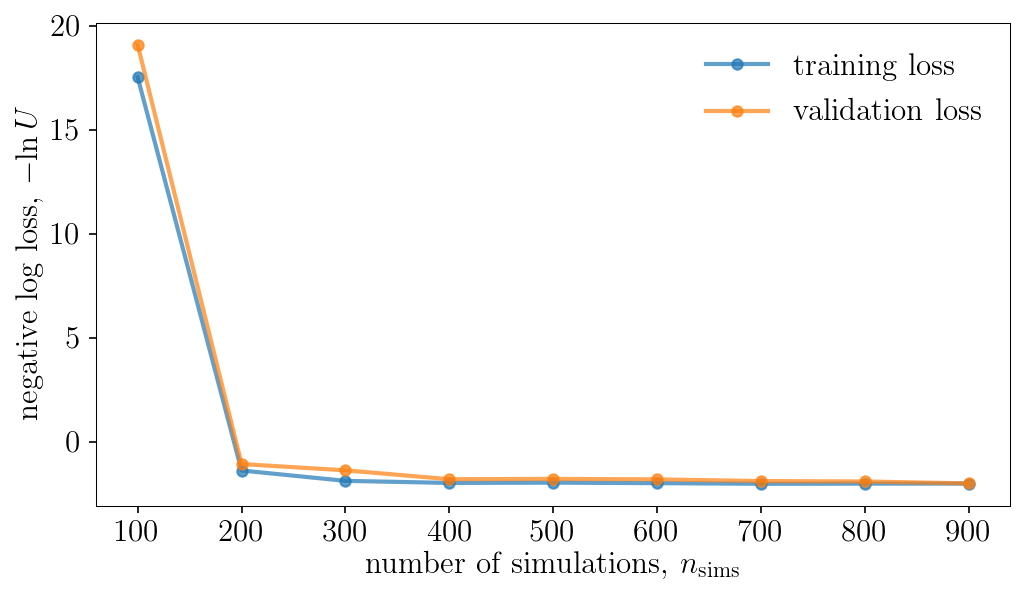

Population 9/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.2465889239992975
simulation time: 4.250856969001688
simulation time: 4.228463376999571
simulation time: 4.232897222998872
simulation time: 4.228540522999538
simulation time: 4.225278170999445
simulation time: 4.238313202000427
simulation time: 4.23735188000137
simulation time: 4.237308669999038
simulation time: 4.250555374999749
simulation time: 4.239589353001065
simulation time: 4.222888708000028
simulation time: 4.242587901000661
simulation time: 4.233787234999909
simulation time: 4.224725425998258
simulation time: 4.2248970580003515
simulation time: 4.218115820000094
simulation time: 4.238899865000349
simulation time: 4.237027089999174
simulation time: 4.235345554001469
simulation time: 4.233832923999216
simulation time: 4.22852495799998
simulation time: 4.219469543999367
simulation time: 4.229940844999874
simulation time: 4.238001177000115
simulation time: 4.242363805999048
simulation time: 4.215628232999734
simulation time: 4.19032304600114
simulation time: 4.21

Sampling approximate posterior...
Done.
Removed no burn in


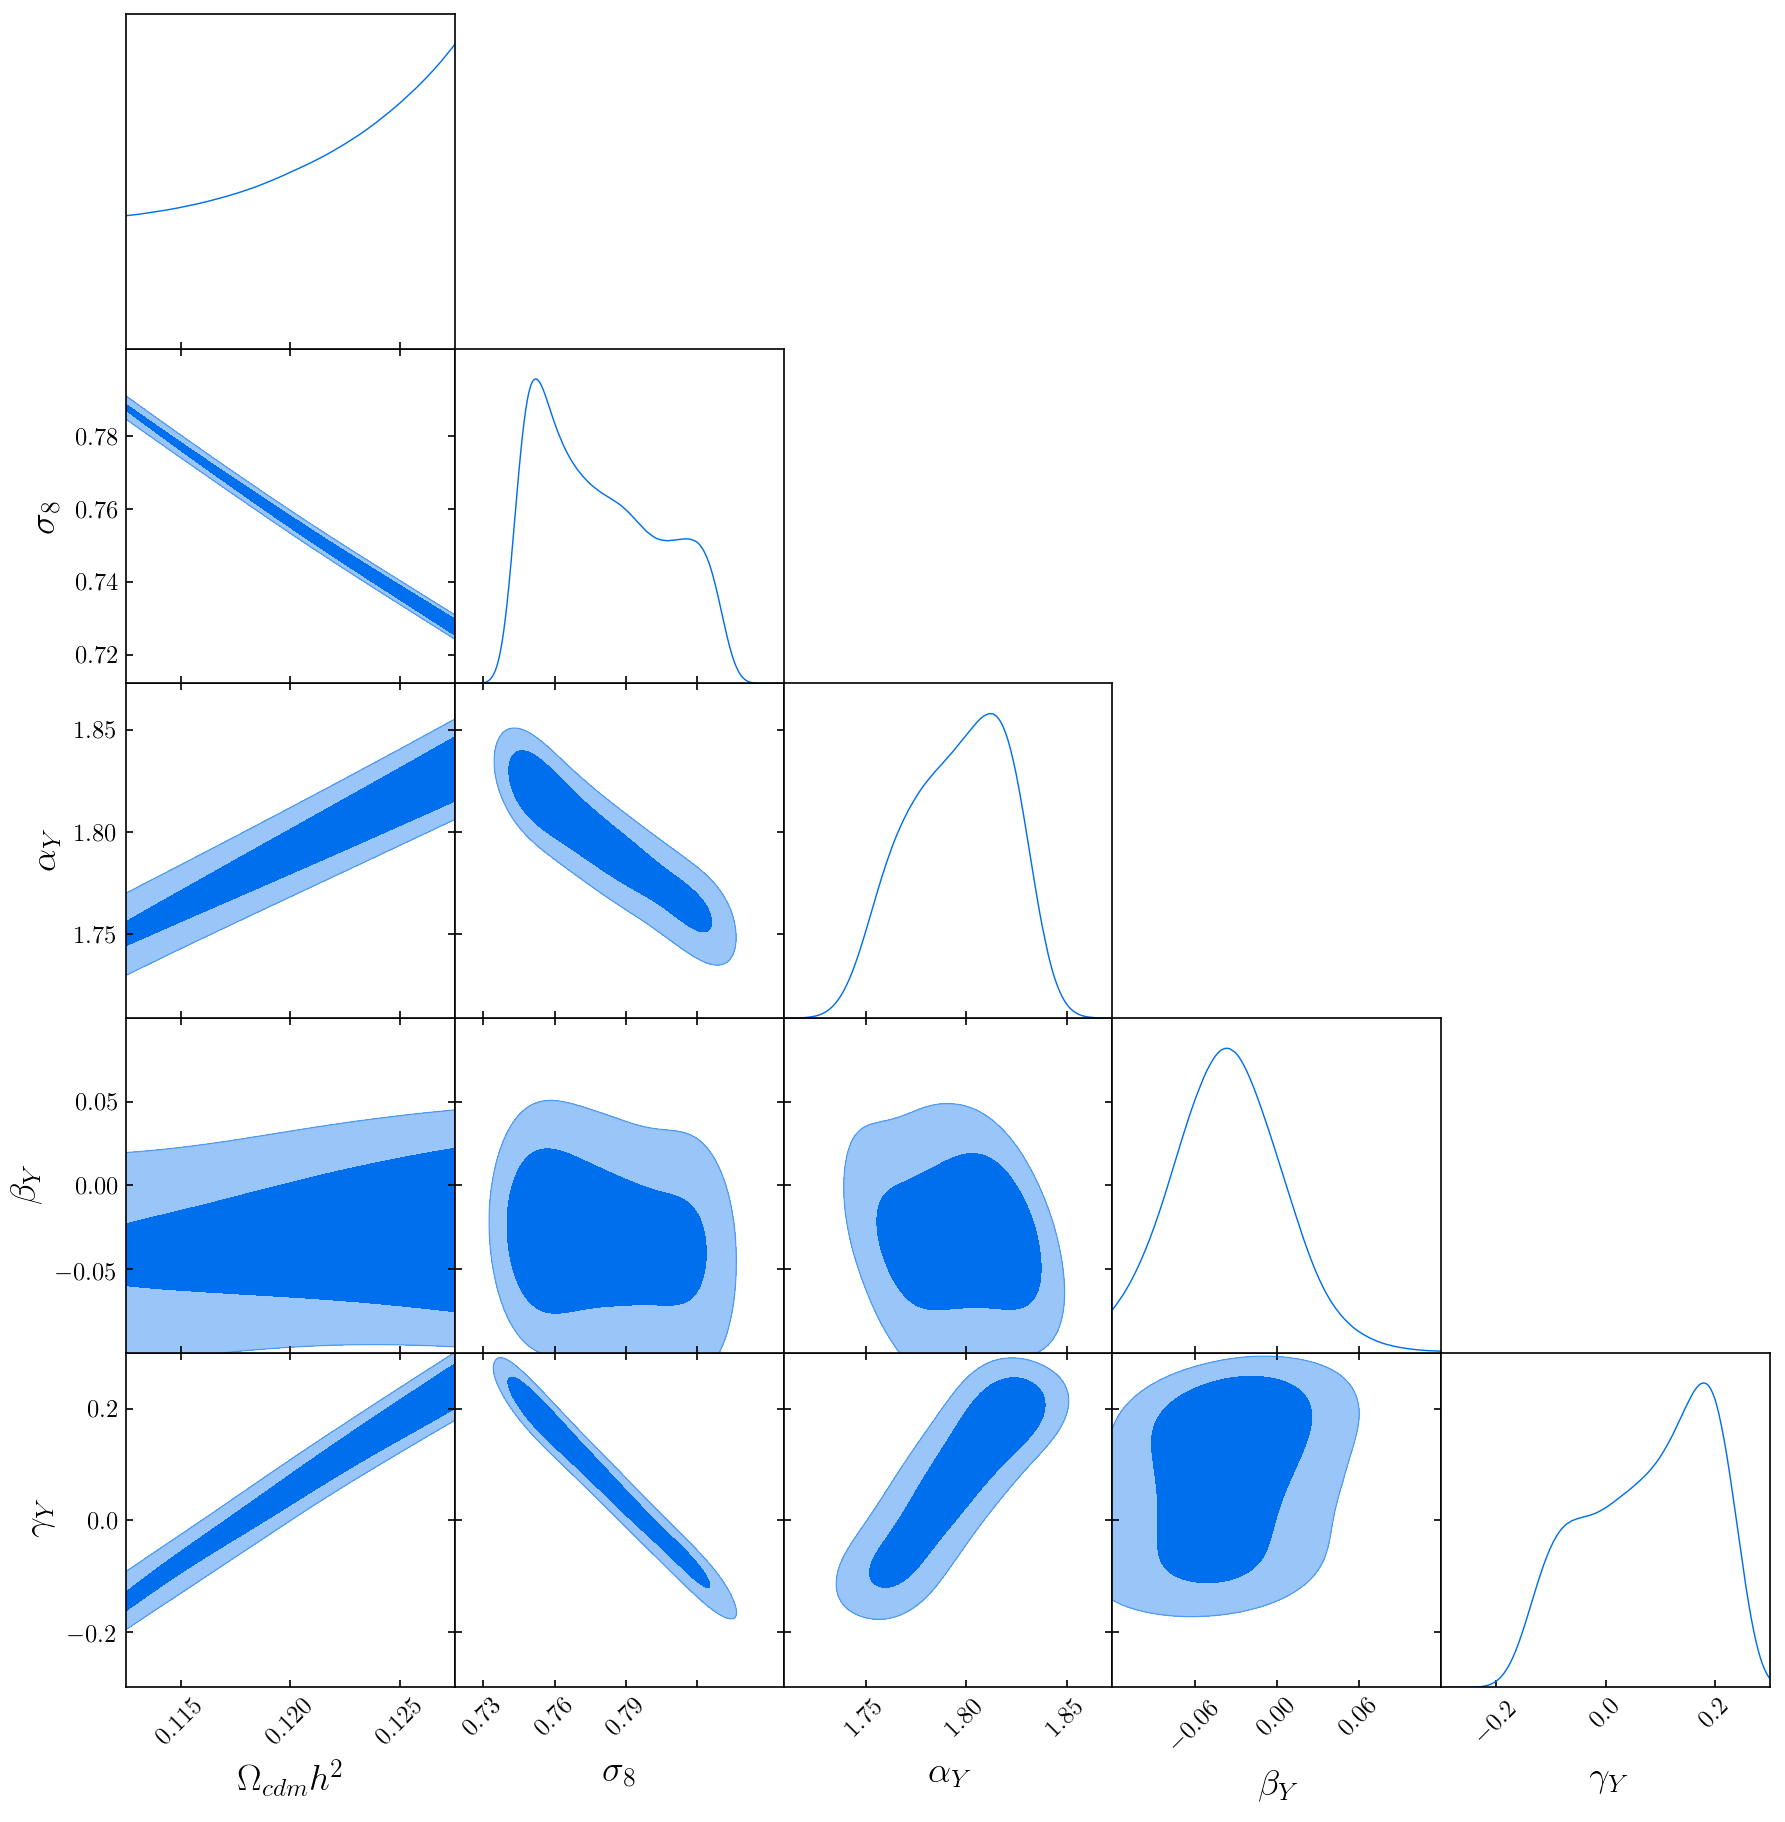

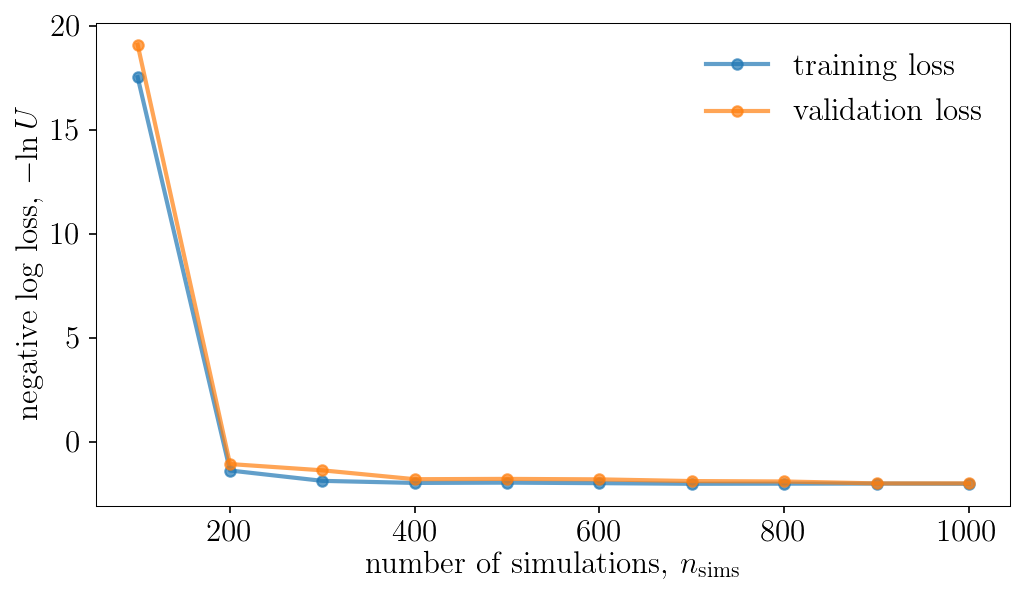

Population 10/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.222327374000088
simulation time: 4.220401430999118
simulation time: 4.247626710000986
simulation time: 4.23767486900033
simulation time: 4.227821028000108
simulation time: 4.234631236000496
simulation time: 4.21461923500101
simulation time: 4.238246753999192
simulation time: 4.247545230000469
simulation time: 4.252161263999369
simulation time: 4.231133802999466
simulation time: 4.233527469999899
simulation time: 4.233378031000029
simulation time: 4.236153101001037
simulation time: 4.2372443709991785
simulation time: 4.225792373999866
simulation time: 4.229336514999886
simulation time: 4.232123346999288
simulation time: 4.232753226000568
simulation time: 4.225675363000846
simulation time: 4.236323498000274
simulation time: 4.241959182001665
simulation time: 4.238568467000732
simulation time: 4.242175690000295
simulation time: 4.2244459119992825
simulation time: 4.231955523000579
simulation time: 4.236126612000589
simulation time: 4.217177918000743
simulation time: 4.2

Sampling approximate posterior...
Done.
Removed no burn in


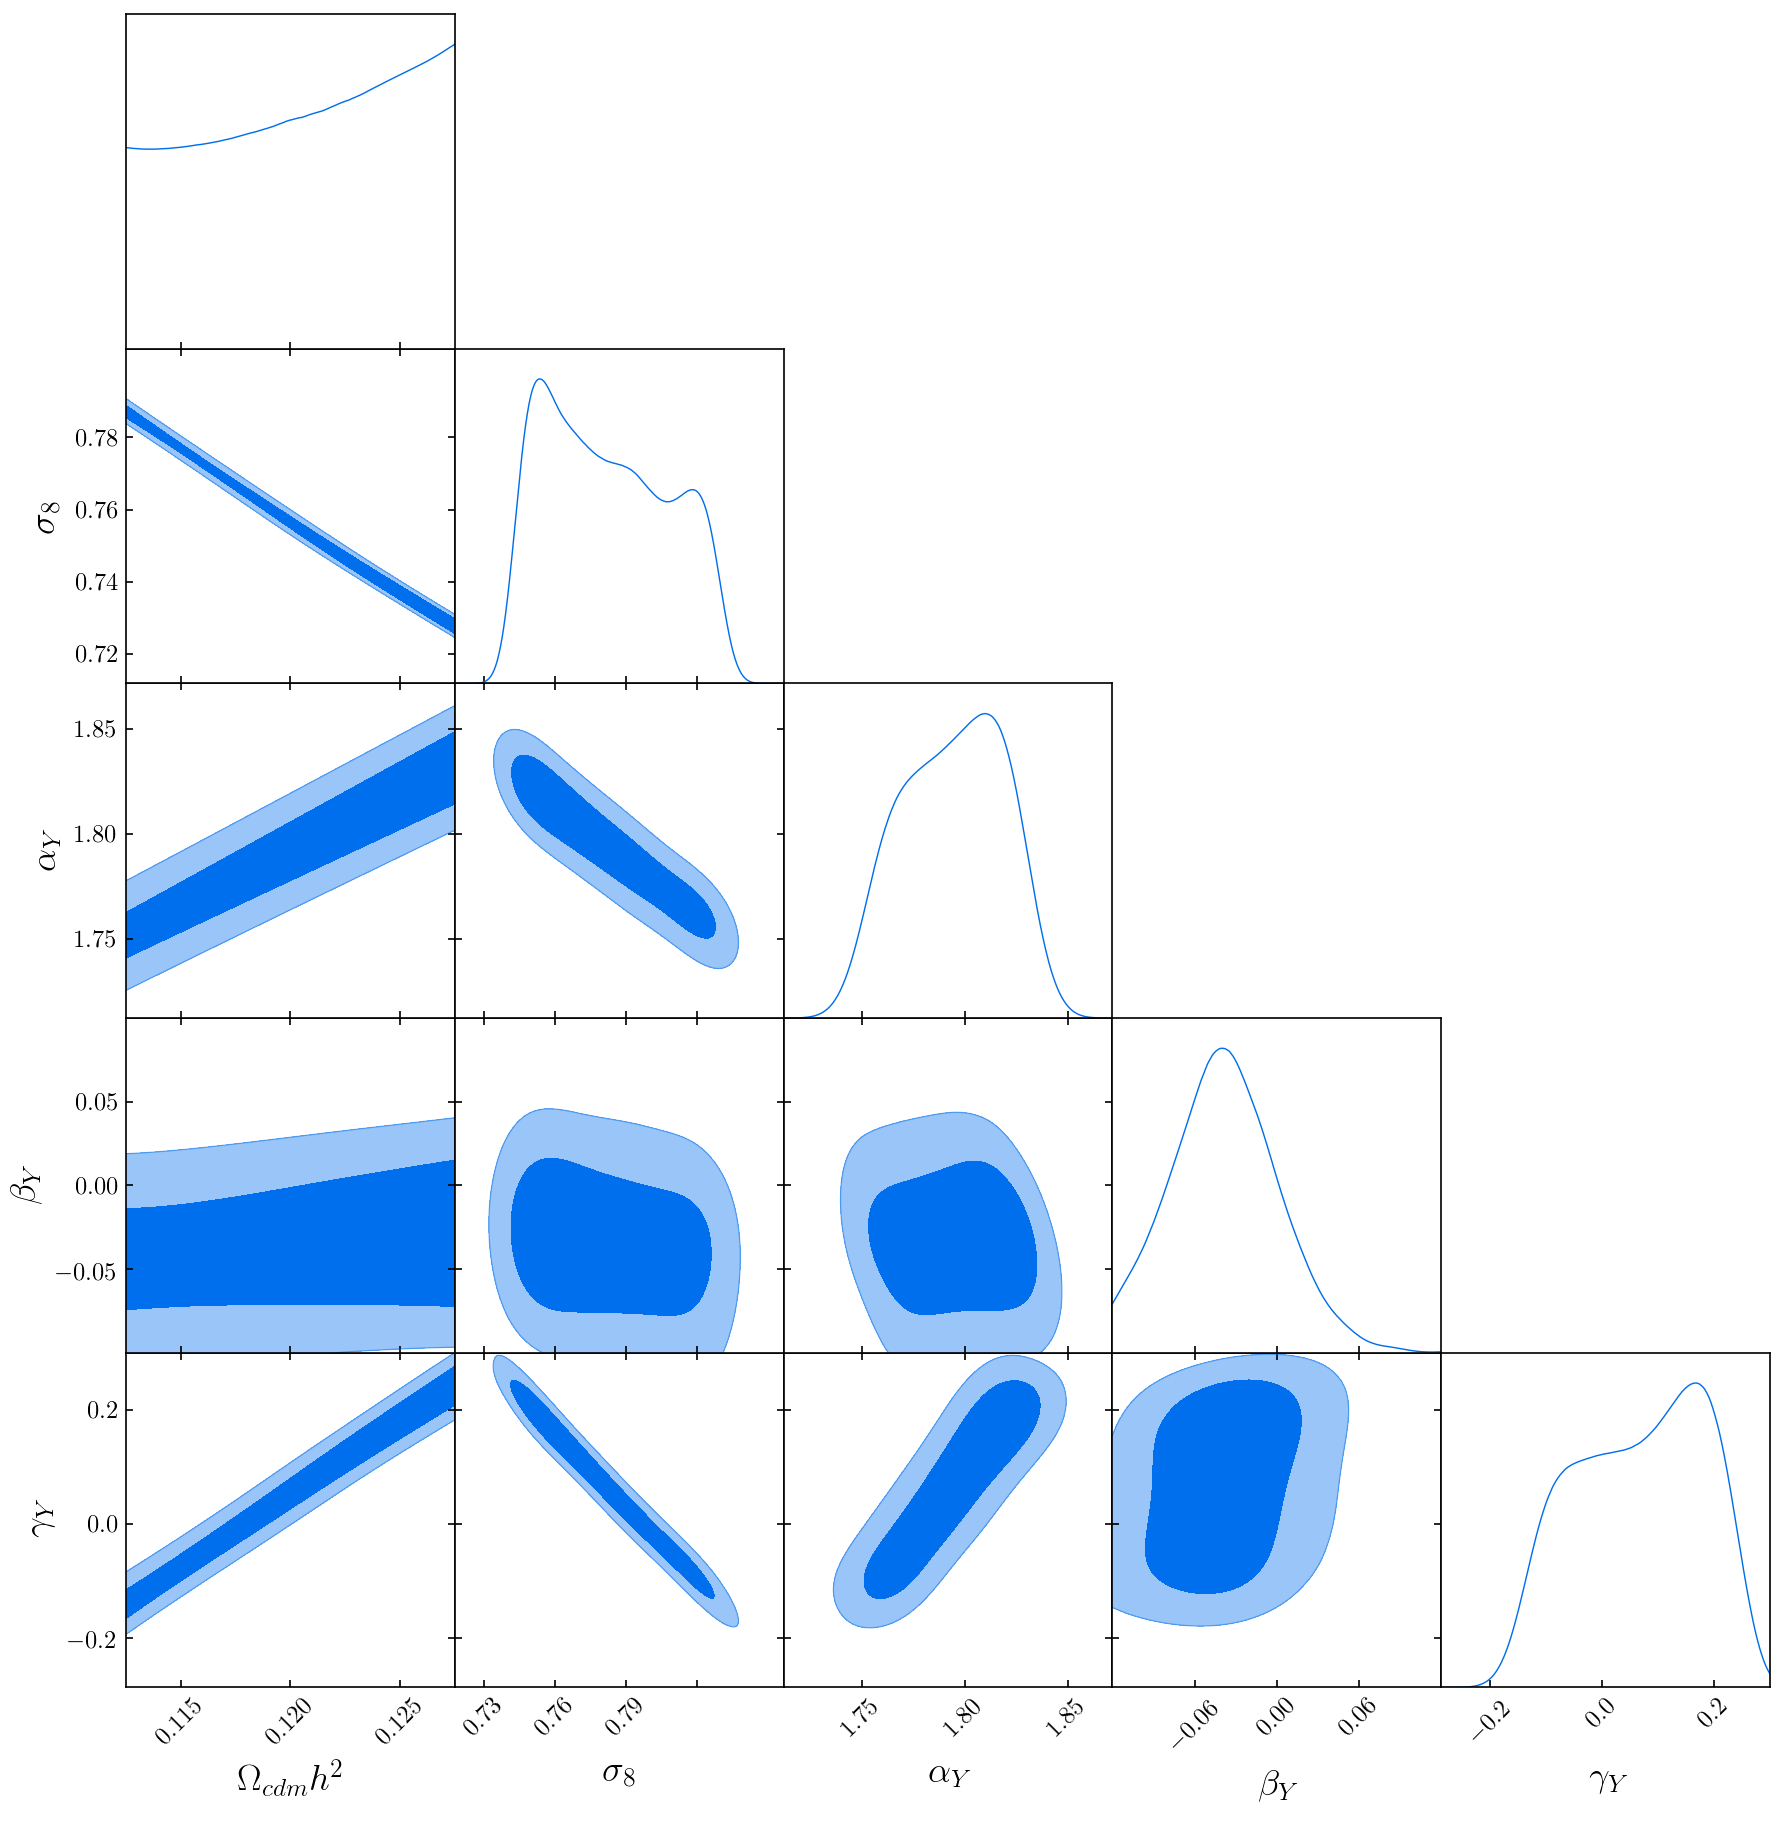

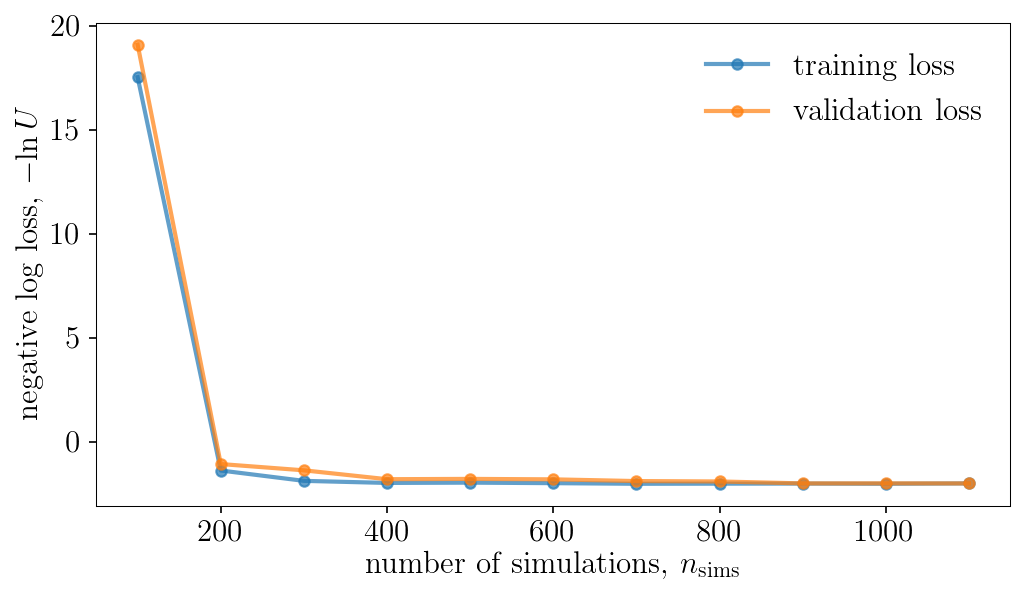

In [52]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)